In [25]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import lightgbm as lgb

shap.initjs()
print(shap.__version__)

0.39.0


In [26]:
params = {
    "max_bin": 128,
    "max_depth": 10,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": 'mae',
    "num_leaves": 100,
    "verbose": -1,
    "min_data": 10,
    "boost_from_average": False,
    "bagging_freq": 1,
    "random_state": 1
}

MAX_DISPLAY = 8

LABEL_COLUMN_NAME1 = 'Velocity (deaths (per 100k)/days)'
LABEL_COLUMN_NAME2 = 'Acceleration (deaths (per 100k)/days^2)'

WANTED_COLUMNS_V = ['Days of outbreak','Death rate from CVDs (per 100k)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 70 years and older (% of population)','40-year olds (males per 100 females)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Deaths from Stroke female (world avg)','Deaths from Stroke male (world avg)','Current health expenditure (% of GDP)','Agglomerations of +1 million (% of urban population)','Share infected with HIV (% of population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from Diabetes female (world avg)','Deaths from Diabetes male (world avg)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Deaths of 70+ years old (% of deaths)','Deaths of 50 to 69 years old (% of deaths)','Deaths of 15 to 49 years old (% of deaths)','Deaths from AIDS female (world avg)','Deaths from AIDS male (world avg)','Deaths from Cancer 15-49 years (world avg)','Deaths from CVDs 15-49 years (world avg)','Deaths from Diabetes 15-49 years (world avg)','Deaths from Cancer 50-69 years (world avg)','Deaths from CVDs 50-69 years (world avg)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','BCG coverage (%)','Critical care beds needed/available','Average temperature (C)','Average relative humidity (%)','Age working dependency ratio','Share of one person households (%)']
WANTED_COLUMNS_A = ['Days of outbreak','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Population living in slums (% urban population)','Transit stations percent change from baseline','Residential percent change from baseline','Critical care beds needed/available','Diabetes prevalence (% of population)','Age working dependency ratio','Share of one person households (%)']

#WANTED_COLUMNS_V = ['Days of outbreak','Stringency','Death rate from CVDs (per 100k)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 70 years and older (% of population)','40-year olds (males per 100 females)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Deaths from Stroke female (world avg)','Deaths from Stroke male (world avg)','Current health expenditure (% of GDP)','Agglomerations of +1 million (% of urban population)','Share infected with HIV (% of population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from Diabetes female (world avg)','Deaths from Diabetes male (world avg)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Deaths of 70+ years old (% of deaths)','Deaths of 50 to 69 years old (% of deaths)','Deaths of 15 to 49 years old (% of deaths)','Deaths from AIDS female (world avg)','Deaths from AIDS male (world avg)','Deaths from Cancer 15-49 years (world avg)','Deaths from CVDs 15-49 years (world avg)','Deaths from Diabetes 15-49 years (world avg)','Deaths from Cancer 50-69 years (world avg)','Deaths from CVDs 50-69 years (world avg)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','BCG coverage (%)','Critical care beds needed/available','Average temperature (C)','Average relative humidity (%)']
#WANTED_COLUMNS_A = ['Days of outbreak','Stringency','Population living in slums (% urban population)','Transit stations percent change from baseline','Residential percent change from baseline','Critical care beds needed/available','Diabetes prevalence (% of population)','Retail and recreation percent change from baseline','Grocery and pharmacy percent change from baseline','Parks percent change from baseline','Workplaces percent change from baseline']

#WANTED_COLUMNS_V = ['Days of outbreak','Death rate from CVDs (per 100k)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 70 years and older (% of population)','40-year olds (males per 100 females)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Deaths from Stroke female (world avg)','Deaths from Stroke male (world avg)','Current health expenditure (% of GDP)','Agglomerations of +1 million (% of urban population)','Share infected with HIV (% of population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from Diabetes female (world avg)','Deaths from Diabetes male (world avg)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Deaths of 70+ years old (% of deaths)','Deaths of 50 to 69 years old (% of deaths)','Deaths of 15 to 49 years old (% of deaths)','Deaths from AIDS female (world avg)','Deaths from AIDS male (world avg)','Deaths from Cancer 15-49 years (world avg)','Deaths from CVDs 15-49 years (world avg)','Deaths from Diabetes 15-49 years (world avg)','Deaths from Cancer 50-69 years (world avg)','Deaths from CVDs 50-69 years (world avg)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','BCG coverage (%)','Critical care beds needed/available','Average temperature (C)','Average relative humidity (%)','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Population living in slums (% urban population)','Days of outbreak','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Population living in slums (% urban population)','Transit stations percent change from baseline','Residential percent change from baseline','Critical care beds needed/available']
#WANTED_COLUMNS_A = ['Days of outbreak','Death rate from CVDs (per 100k)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 70 years and older (% of population)','40-year olds (males per 100 females)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Deaths from Stroke female (world avg)','Deaths from Stroke male (world avg)','Current health expenditure (% of GDP)','Agglomerations of +1 million (% of urban population)','Share infected with HIV (% of population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from Diabetes female (world avg)','Deaths from Diabetes male (world avg)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Deaths of 70+ years old (% of deaths)','Deaths of 50 to 69 years old (% of deaths)','Deaths of 15 to 49 years old (% of deaths)','Deaths from AIDS female (world avg)','Deaths from AIDS male (world avg)','Deaths from Cancer 15-49 years (world avg)','Deaths from CVDs 15-49 years (world avg)','Deaths from Diabetes 15-49 years (world avg)','Deaths from Cancer 50-69 years (world avg)','Deaths from CVDs 50-69 years (world avg)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','BCG coverage (%)','Critical care beds needed/available','Average temperature (C)','Average relative humidity (%)','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Population living in slums (% urban population)','Days of outbreak','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Population living in slums (% urban population)','Transit stations percent change from baseline','Residential percent change from baseline','Critical care beds needed/available']

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    125.23             3756.86
Prediction (s.d.)         120.39 (0.27)      3611.81 (8.04)
95% CI                    [119.88, 120.93]   [3596.28, 3627.8]

Absolute effect (s.d.)    4.84 (0.27)        145.06 (8.04)
95% CI                    [4.3, 5.35]        [129.06, 160.58]

Relative effect (s.d.)    4.02% (0.22%)      4.02% (0.22%)
95% CI                    [3.57%, 4.45%]     [3.57%, 4.45%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 125.23. By contrast, in the absence of an
intervention, we would have expected an average response of 120.39.
The 95% interval of this counterfactual prediction is [119.88, 120.93].
Subtracting this prediction from t

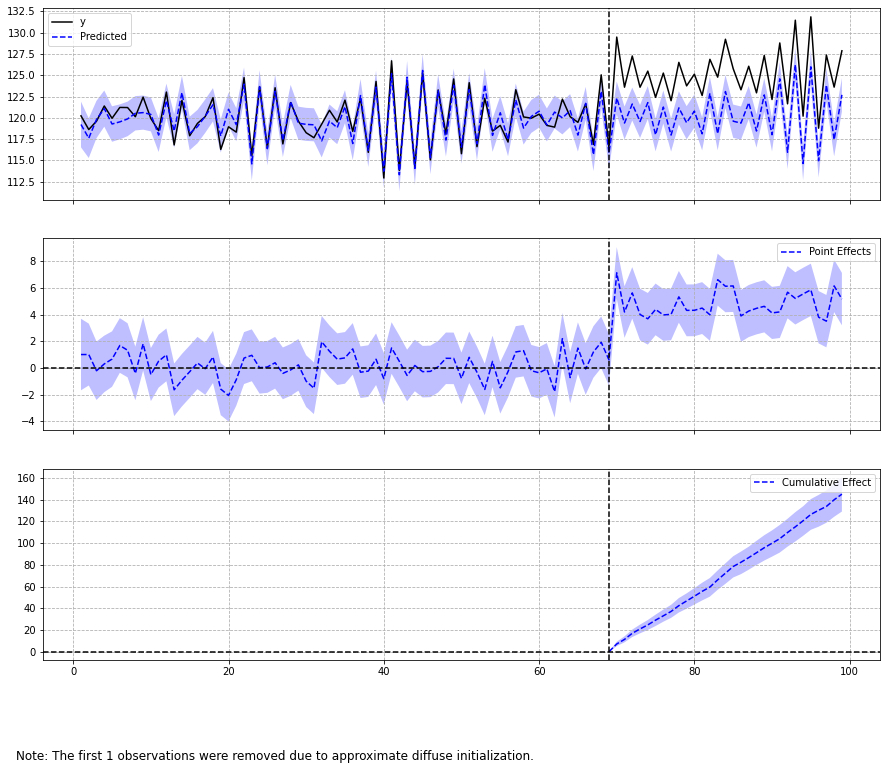

In [27]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact


np.random.seed(12345)
ar = np.r_[1, 0.9]
ma = np.array([1])
arma_process = ArmaProcess(ar, ma)
X = 100 + arma_process.generate_sample(nsample=100)
y = 1.2 * X + np.random.normal(size=100)
y[70:] += 5

data = pd.DataFrame({'y': y, 'X': X}, columns=['y', 'X'])
pre_period = [0, 69]
post_period = [70, 99]

ci = CausalImpact(data, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()


In [28]:
df1 = pd.read_csv('train-SWEDEN.csv')
df2 = pd.read_csv('val-SWEDEN.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
y_pred  = gbm.predict(X_val)
print(mean_absolute_error(y_val, y_pred))

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
y_pred  = gbm.predict(X_val)
print(mean_absolute_error(y_val, y_pred))

0.005437810154863019
0.0003745710011934532


0 0.003187 0.003357489160030065


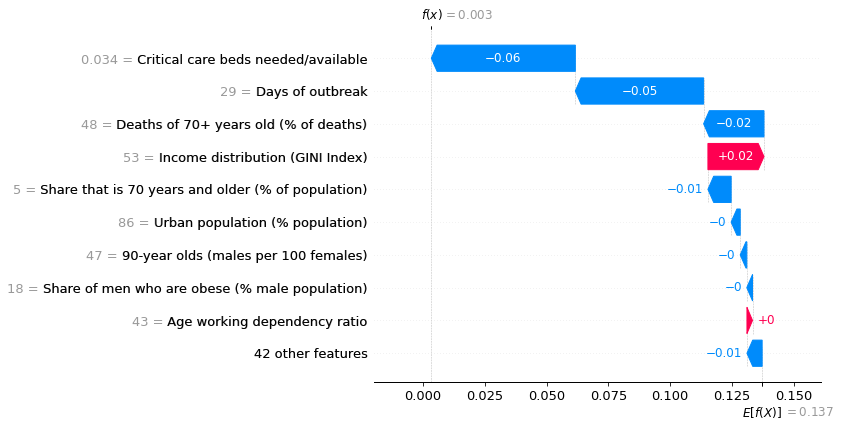

1 0.004221 0.004341516843426858


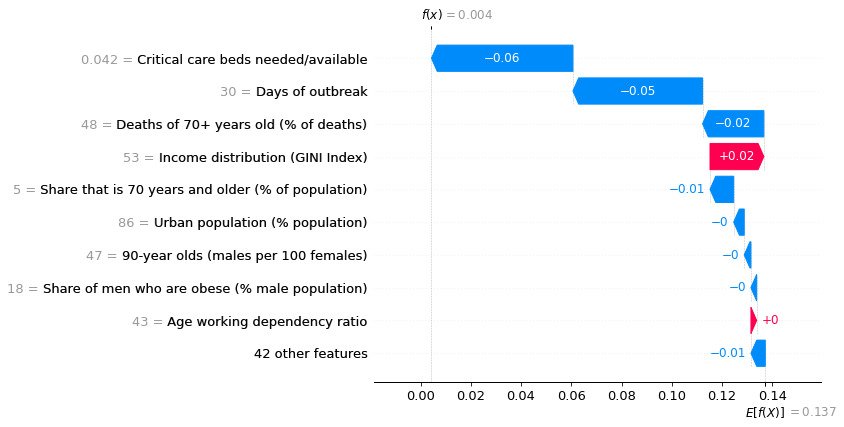

2 0.005029 0.006801750600425236


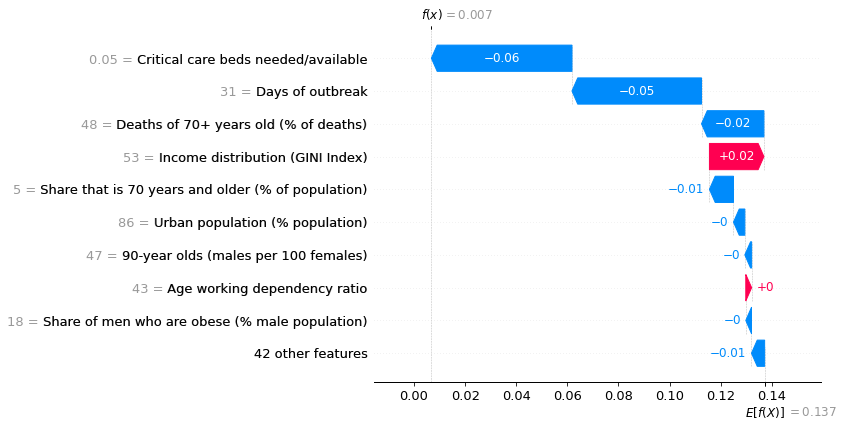

3 0.005979 0.007268911616055521


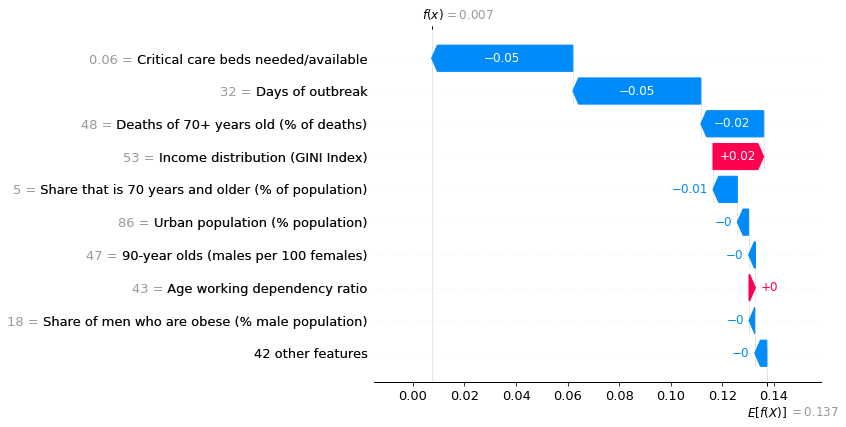

4 0.007699 0.007731473125286238


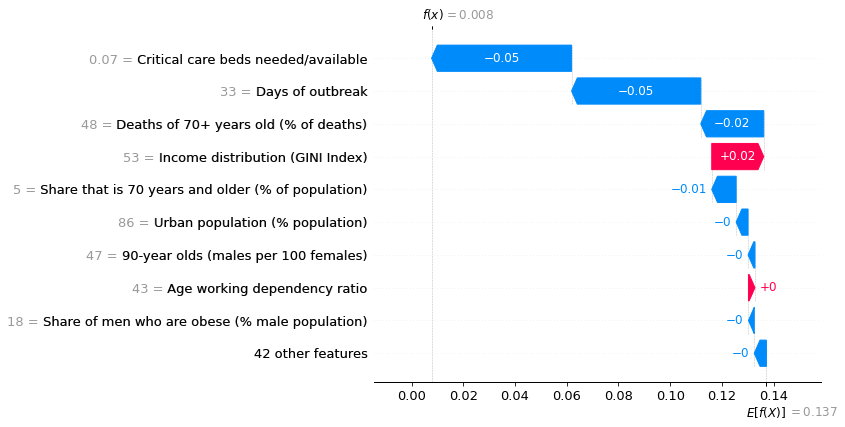

5 0.009739 0.009001347410566596


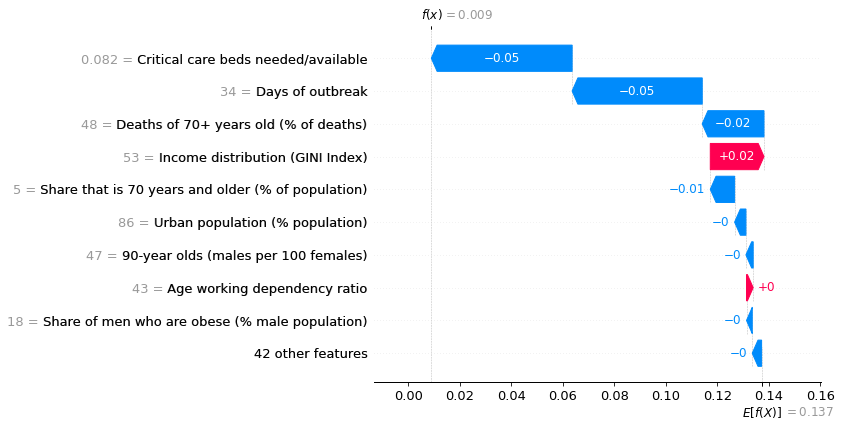

6 0.011326 0.011508617749993975


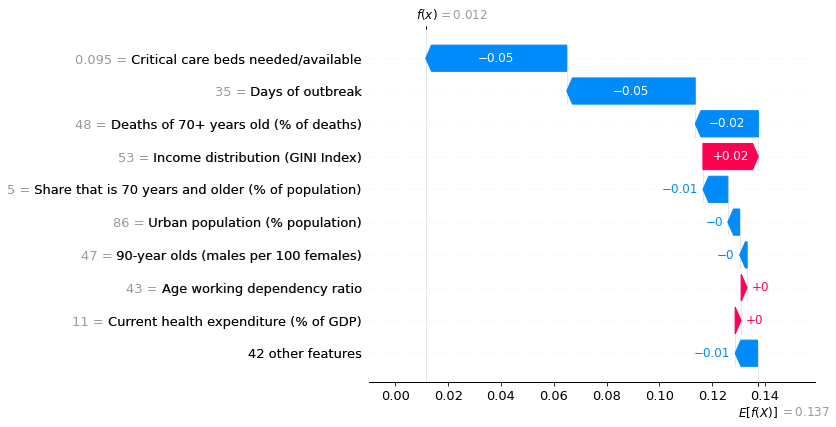

7 0.013084 0.013343610943298879


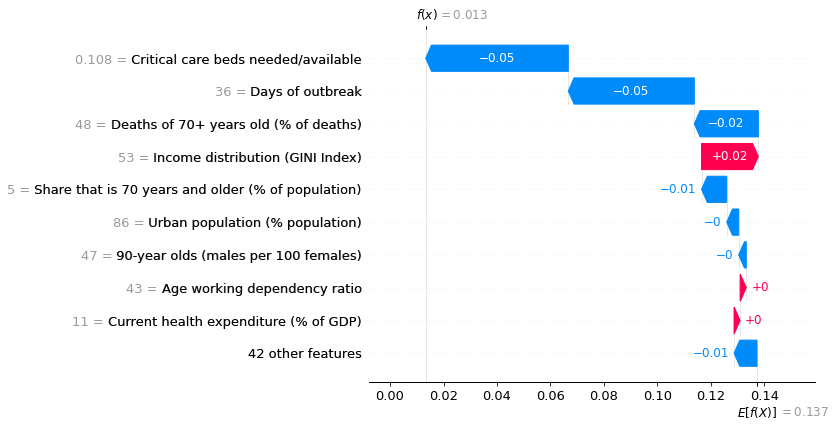

8 0.015001 0.014828645607030339


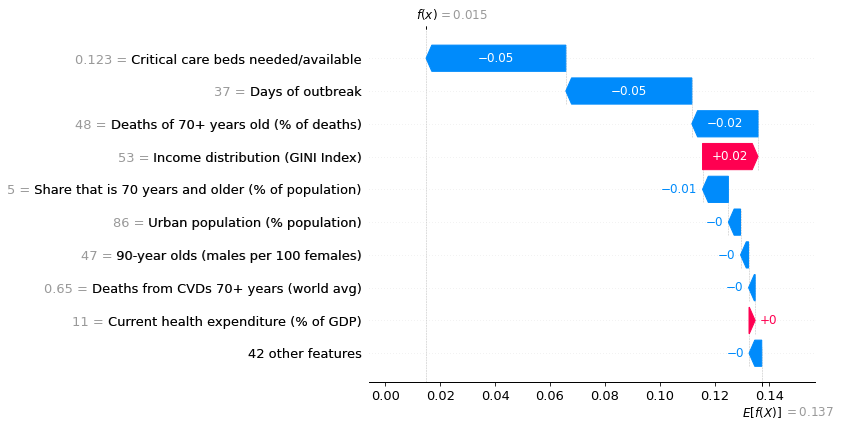

9 0.018152 0.015237196337659282


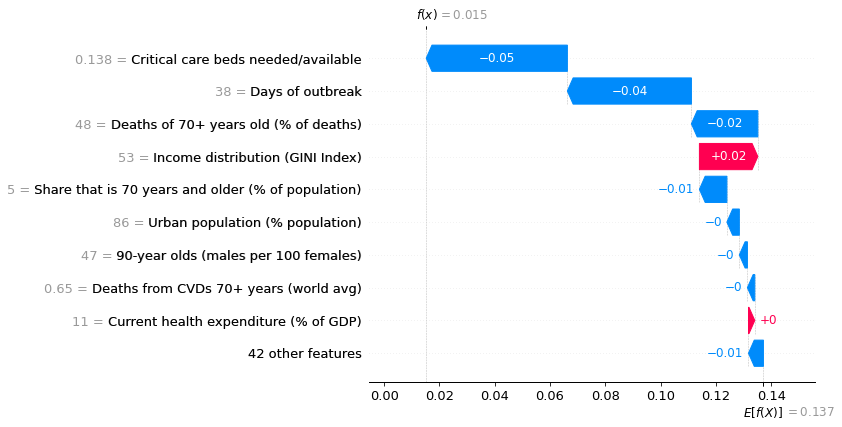

10 0.021526 0.01931119944264294


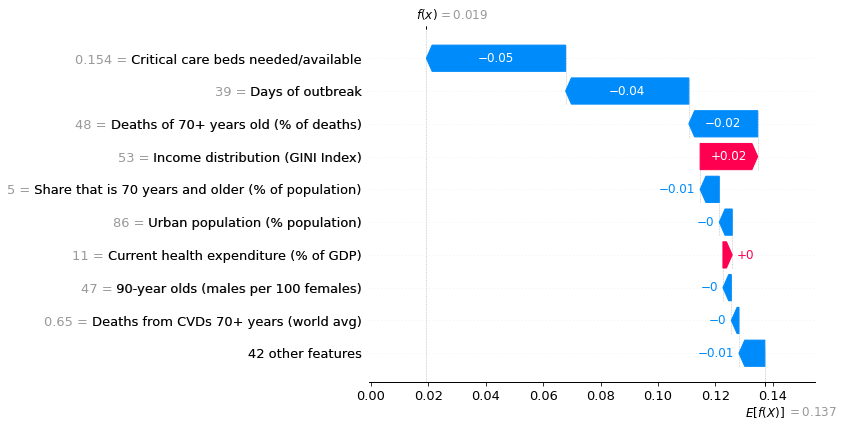

11 0.023894 0.021407940460805852


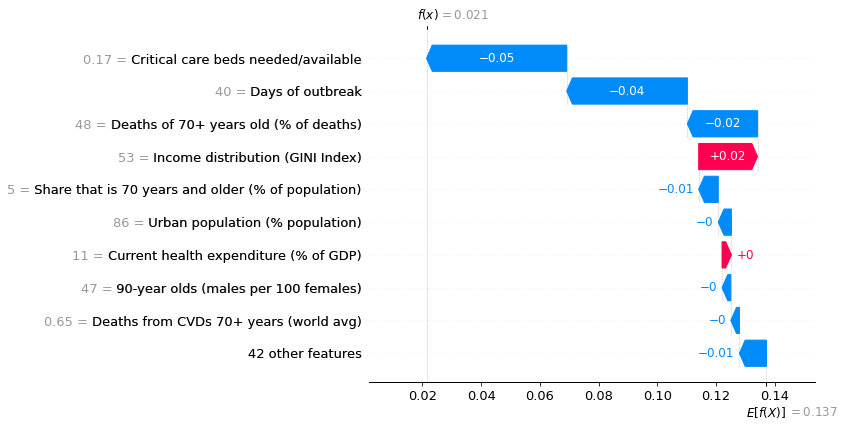

12 0.026332 0.02155274658159541


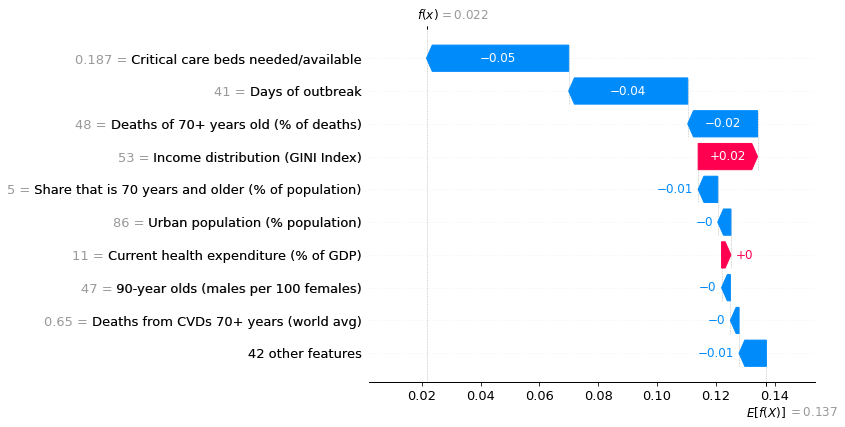

13 0.030105 0.032063738489183945


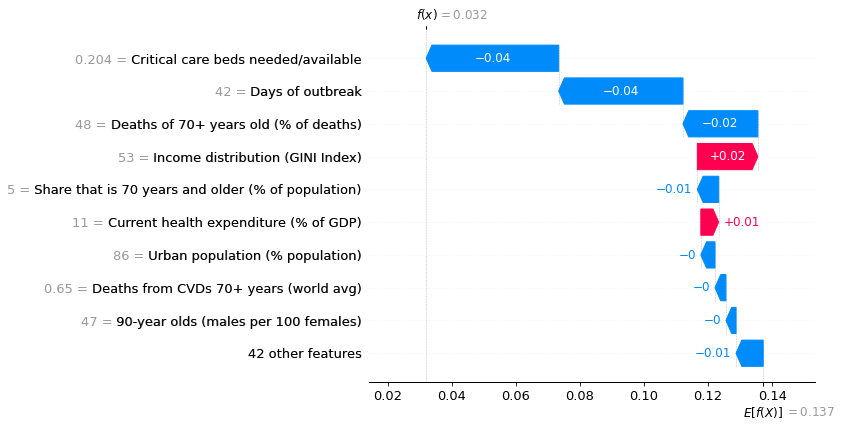

14 0.033981 0.03225513146927187


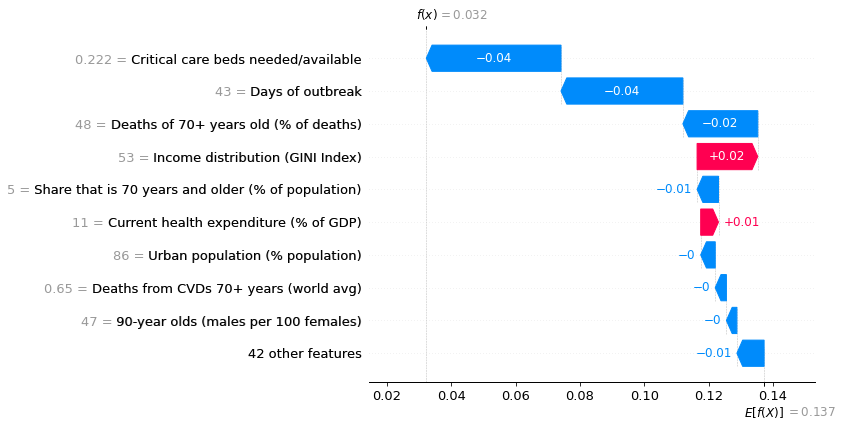

15 0.036633 0.04008194718680781


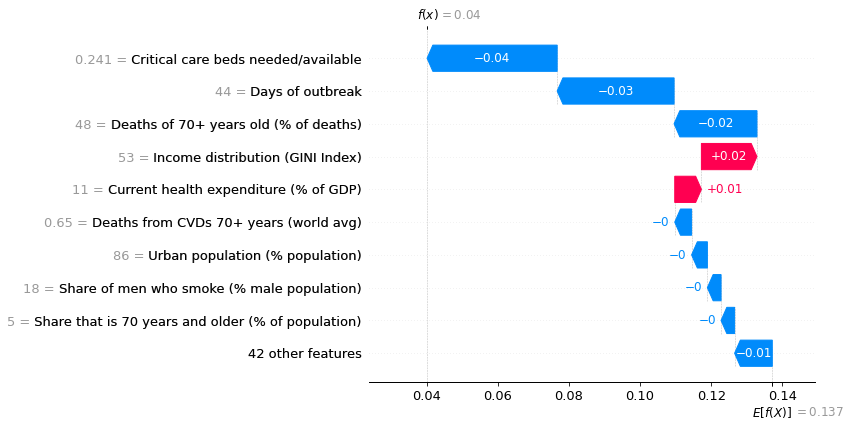

16 0.039339 0.041473409742020455


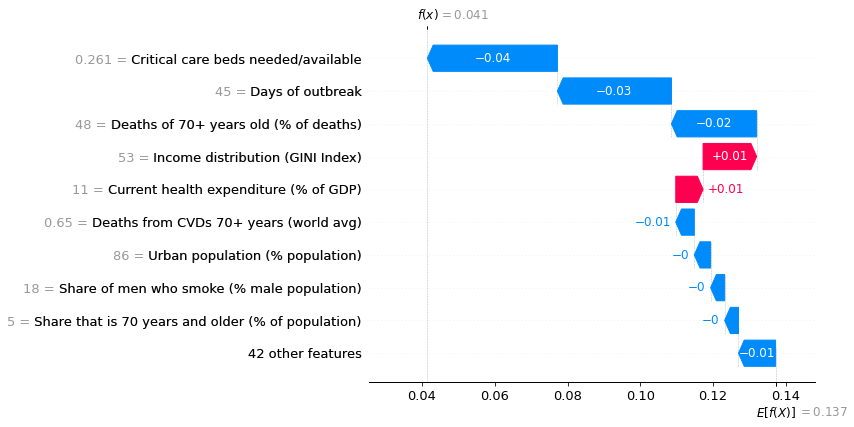

17 0.042107 0.045381896765655474


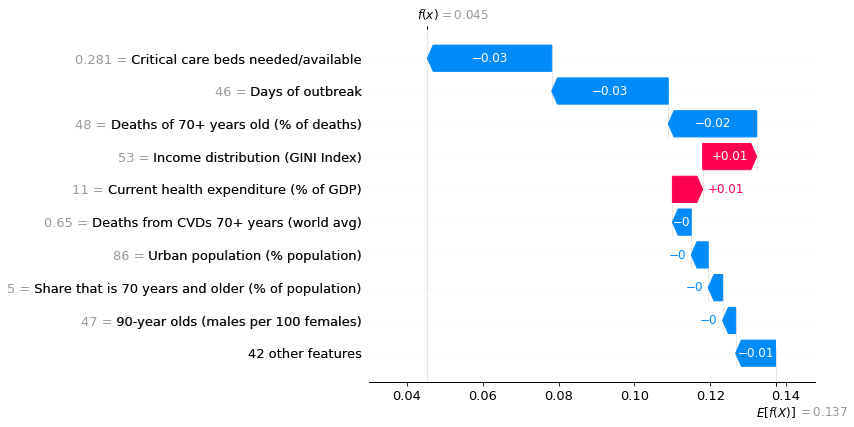

18 0.046405 0.04531738981137523


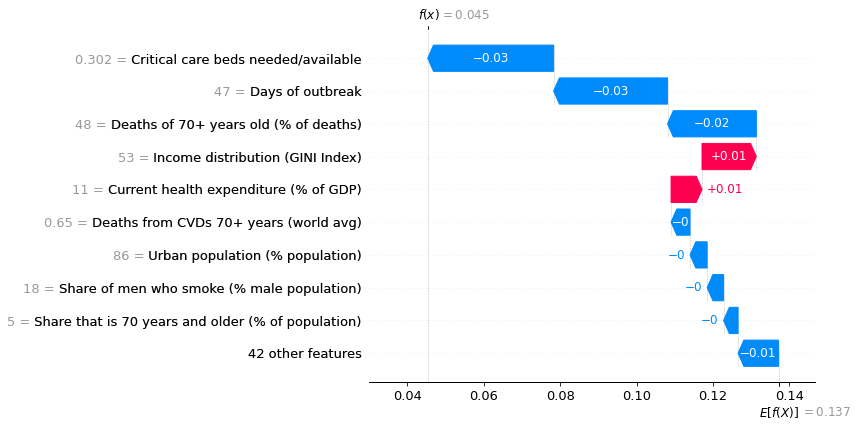

19 0.050877 0.053282150470608344


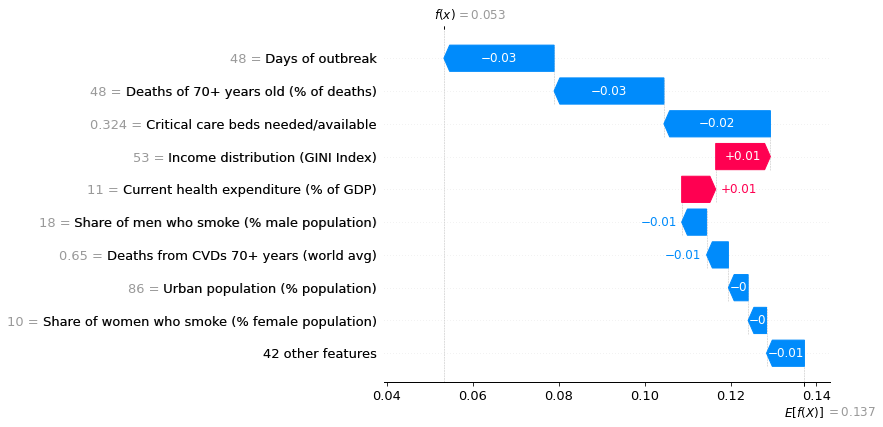

20 0.053996 0.057983187507015685


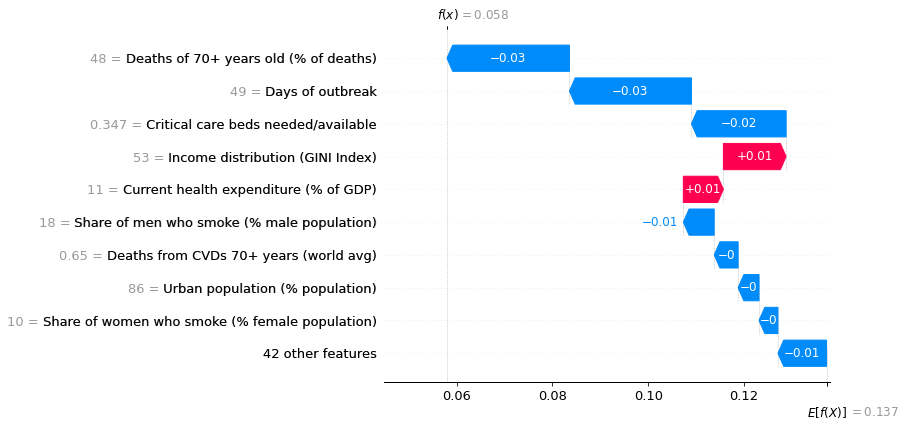

21 0.057236 0.058478273867243934


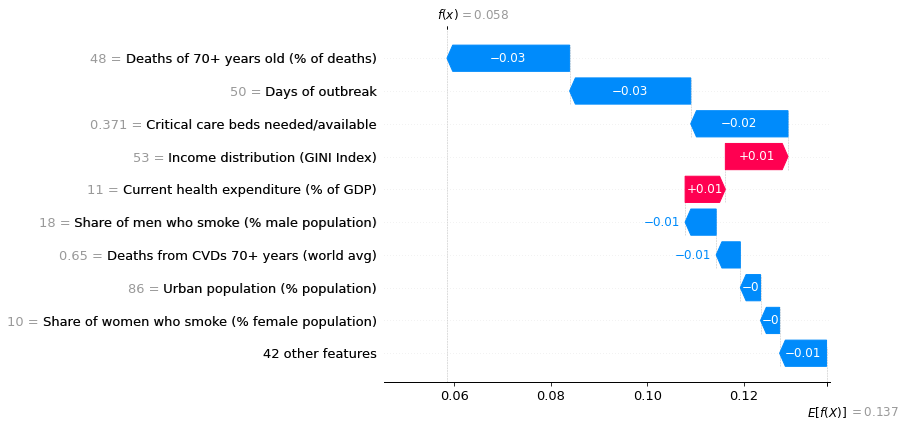

22 0.06237 0.05952190468734738


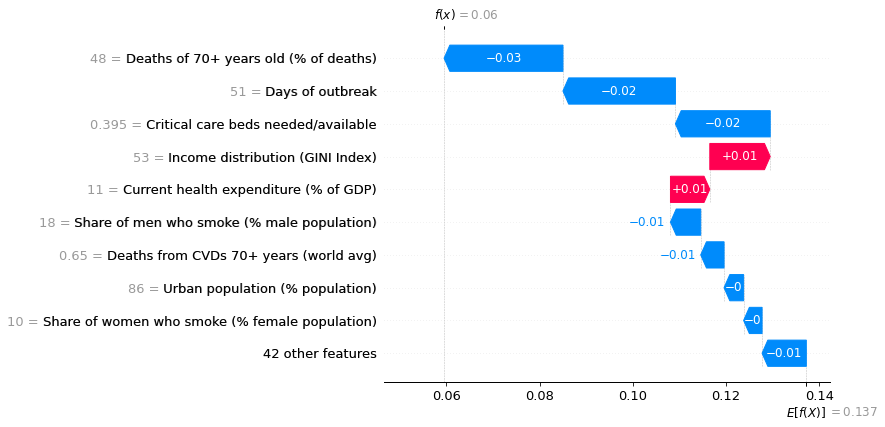

23 0.067811 0.06646602368106104


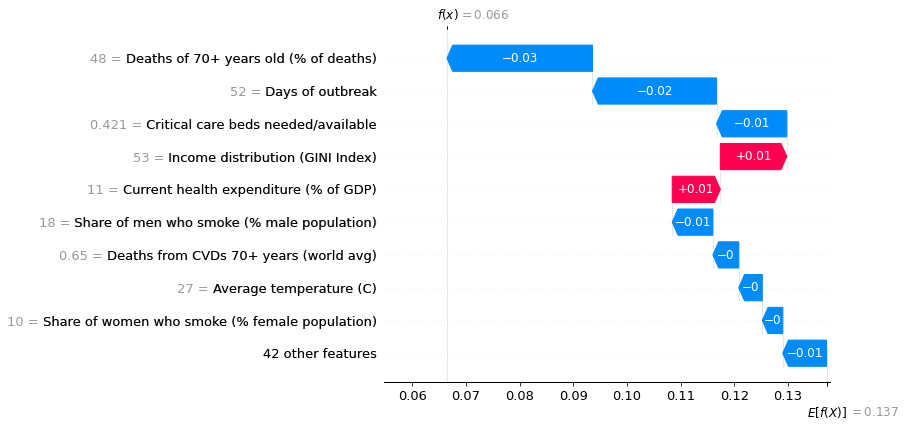

24 0.071662 0.07117623360299086


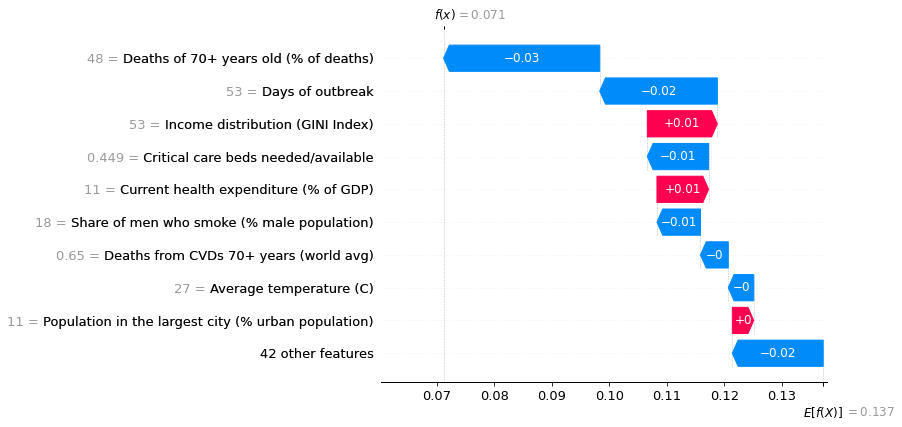

25 0.075691 0.0812700595465911


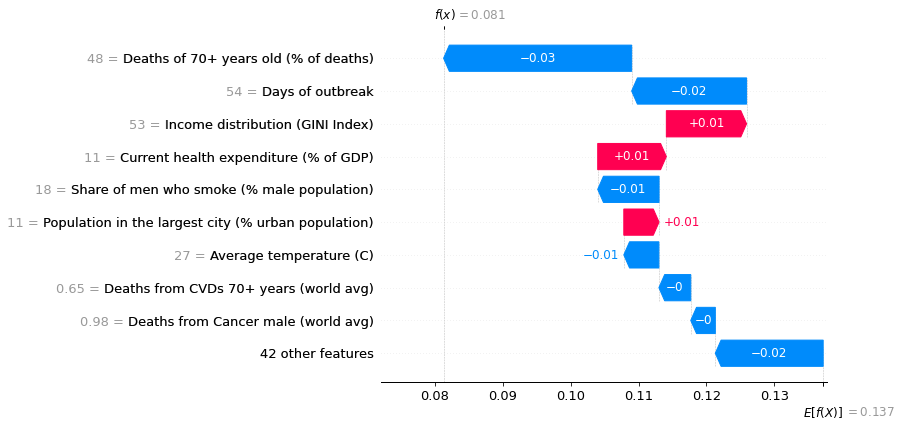

26 0.079906 0.08219280984740607


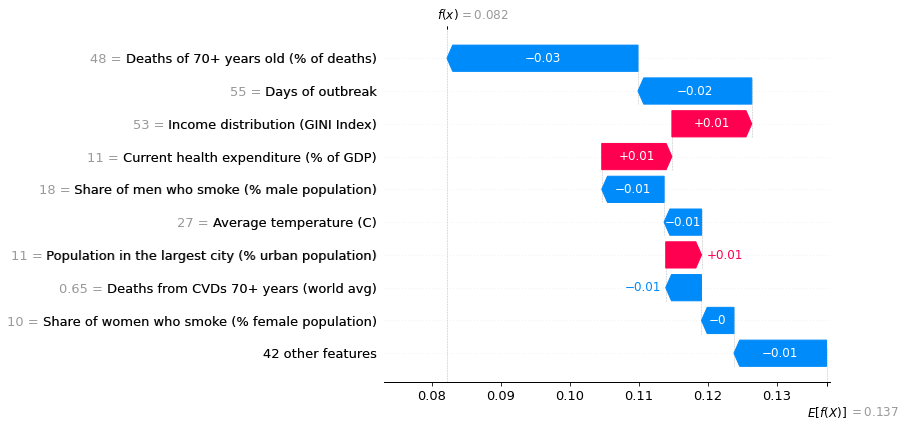

27 0.086613 0.08962323425127437


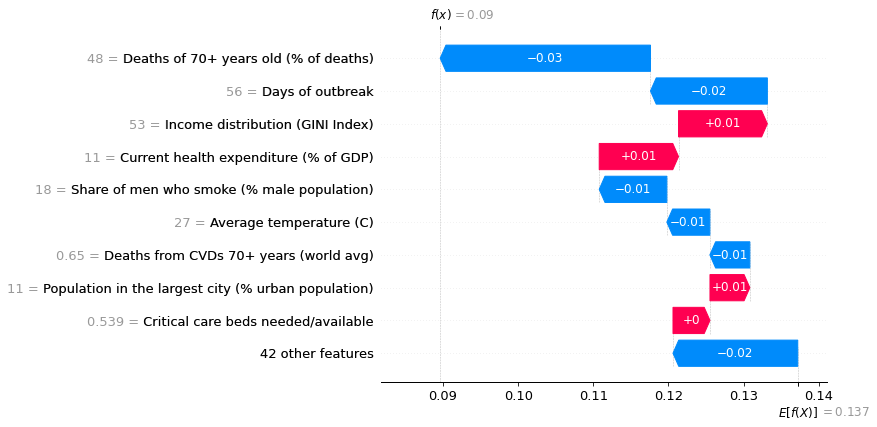

28 0.093713 0.0903239473668679


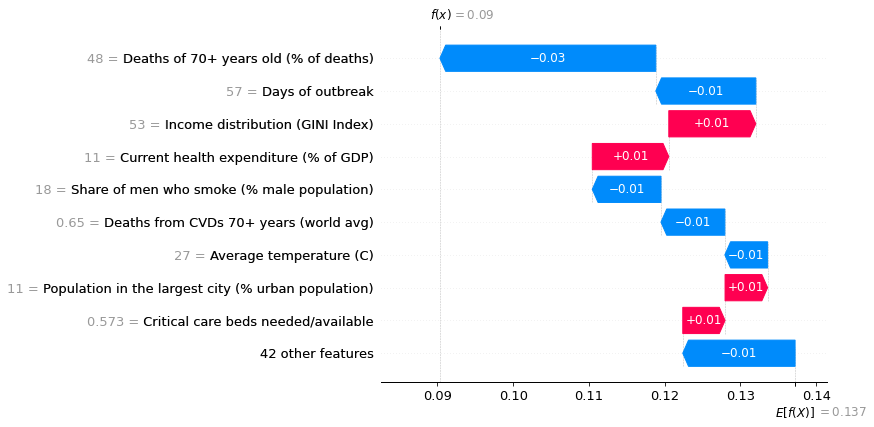

29 0.09871 0.1027544111322


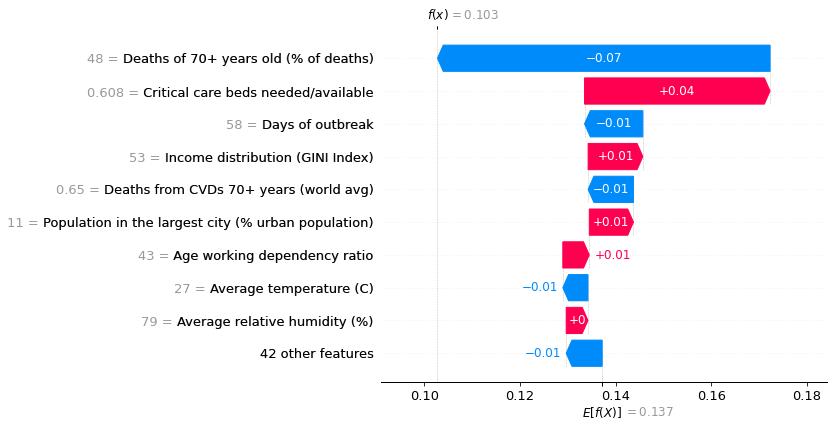

30 0.103903 0.10441989792407982


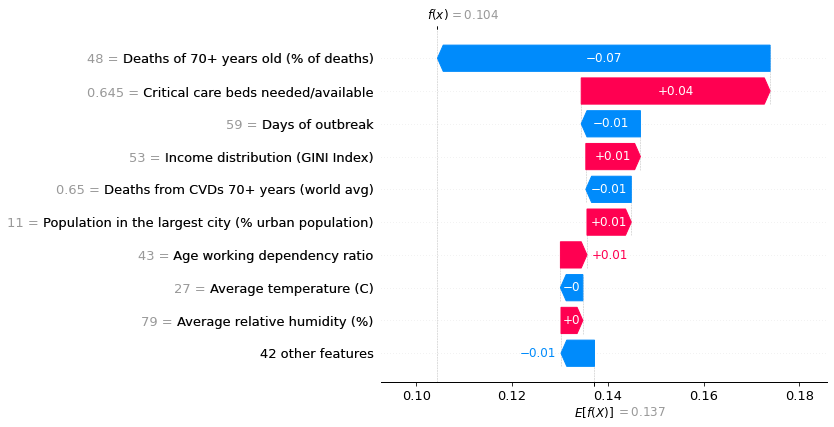

31 0.112079 0.10666046669148489


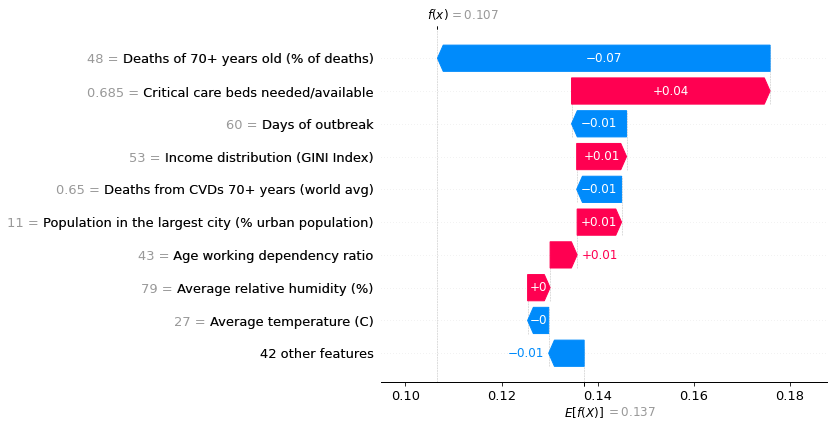

32 0.12063 0.1210743441056432


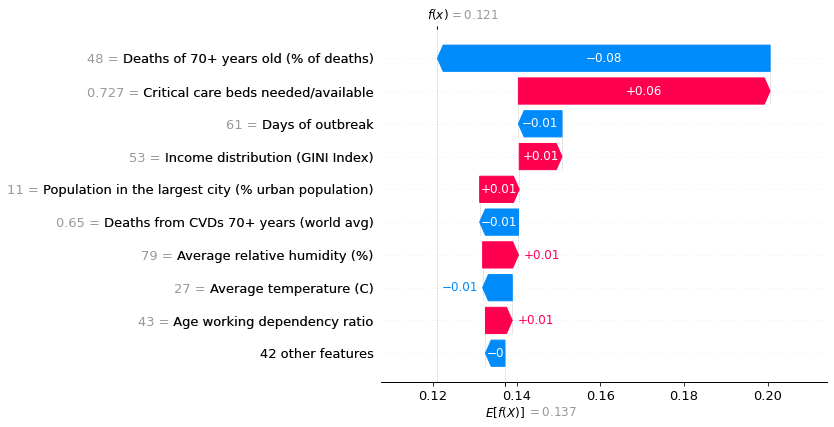

33 0.126571 0.1270542864897836


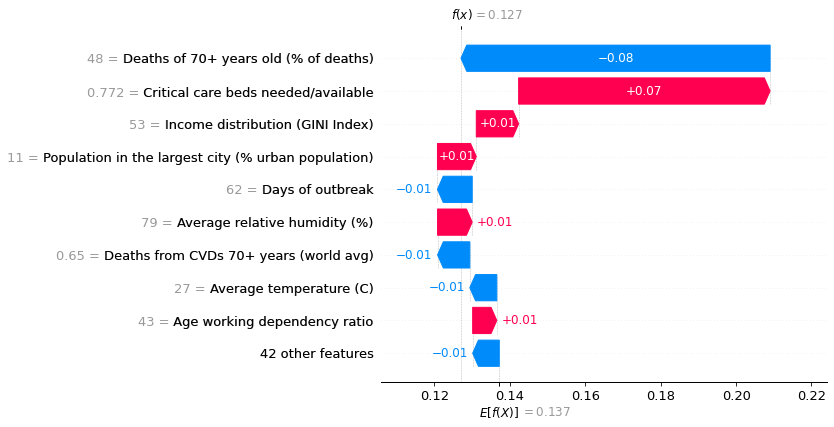

34 0.132685 0.12873956106816753


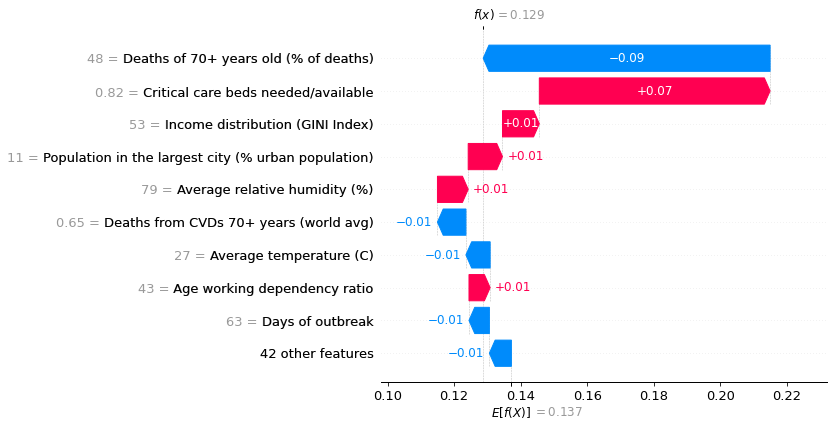

35 0.138964 0.13991823456872704


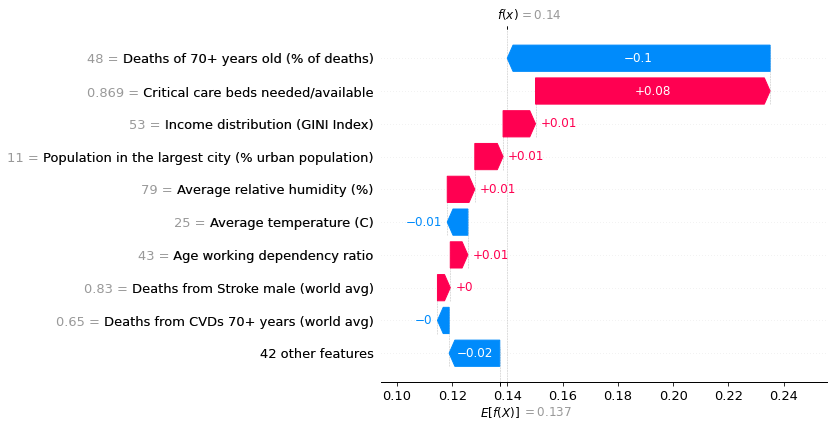

36 0.148693 0.1527958428913927


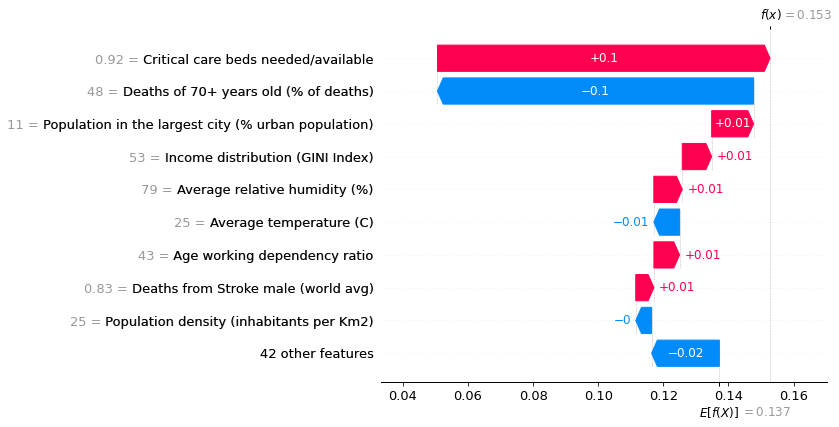

37 0.15871 0.15442635107266822


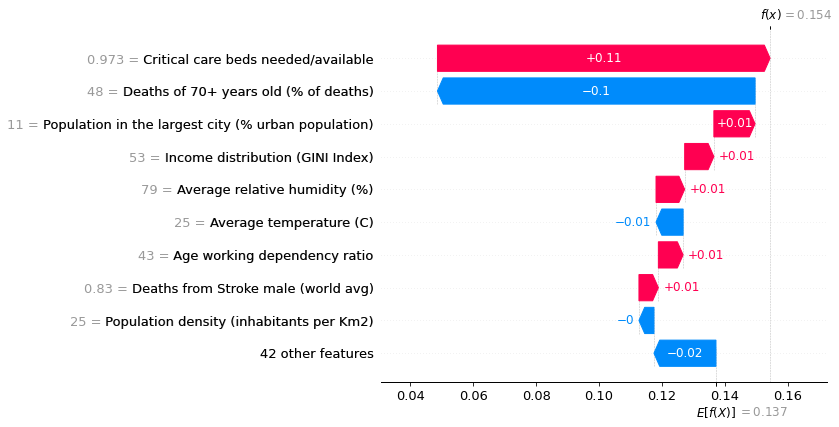

38 0.165565 0.16808428008694068


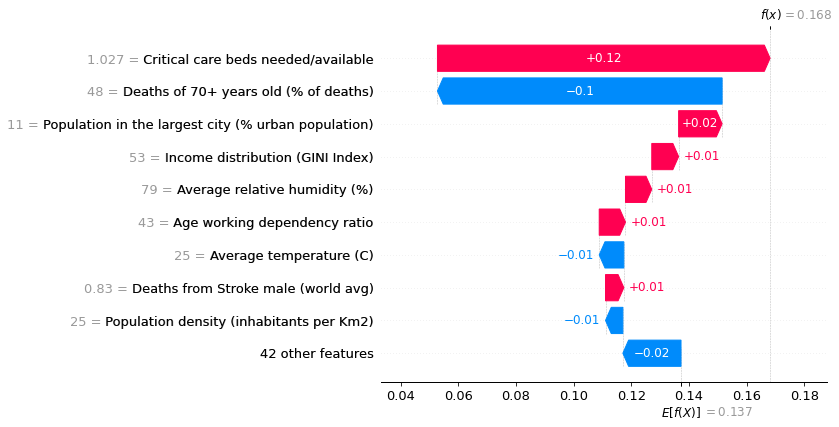

39 0.172543 0.17919313954823368


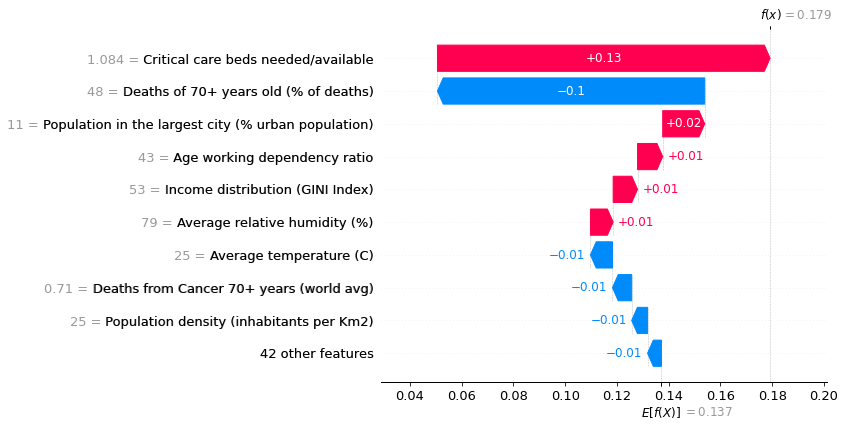

40 0.183226 0.1846834038873615


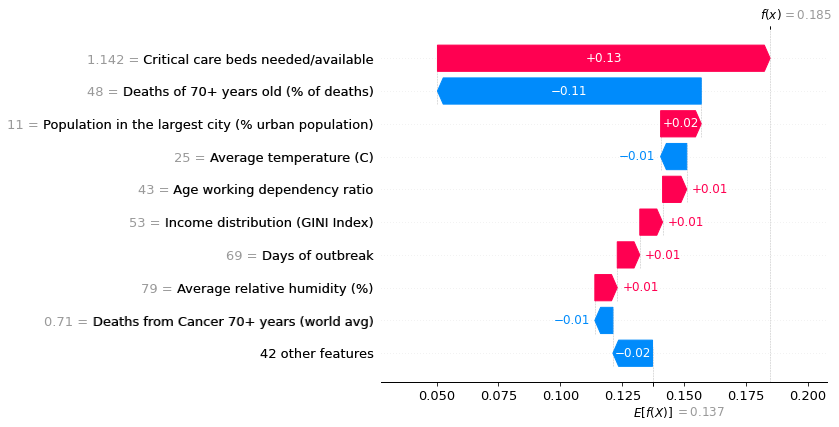

41 0.194101 0.189213897726


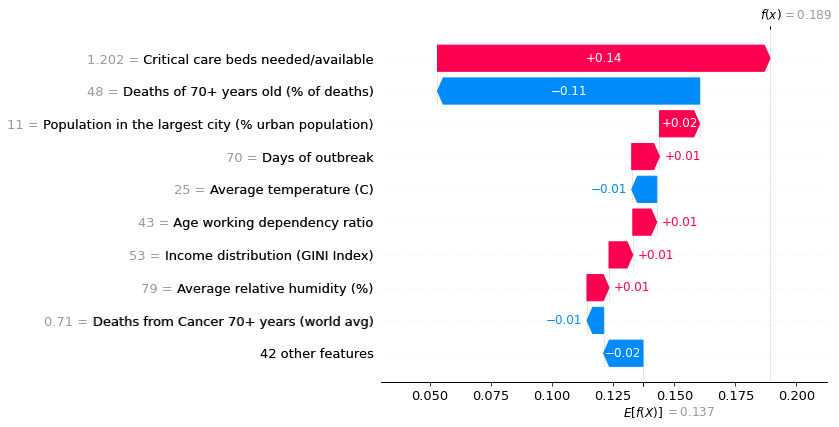

42 0.201459 0.19699967879121502


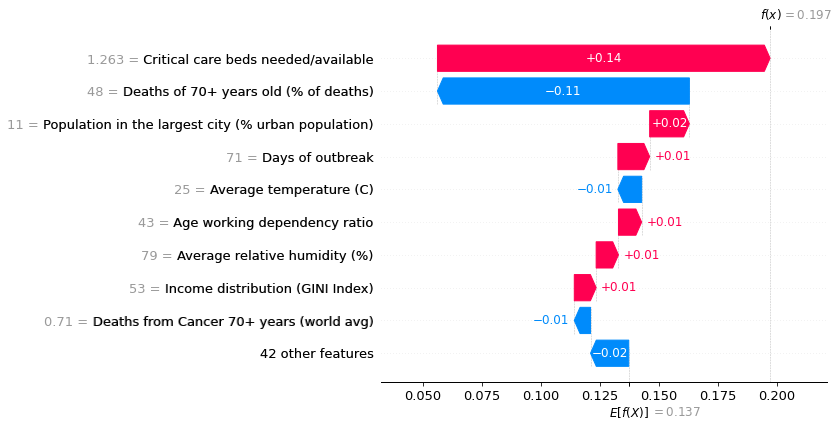

43 0.208881 0.2080108874108246


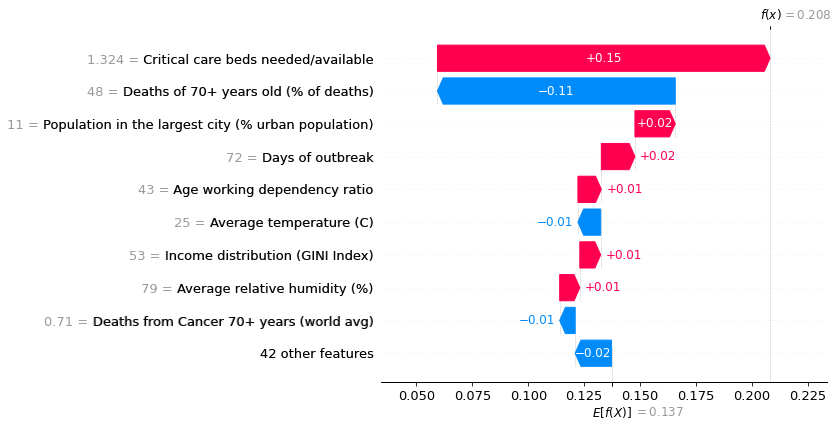

44 0.216355 0.21878869358908842


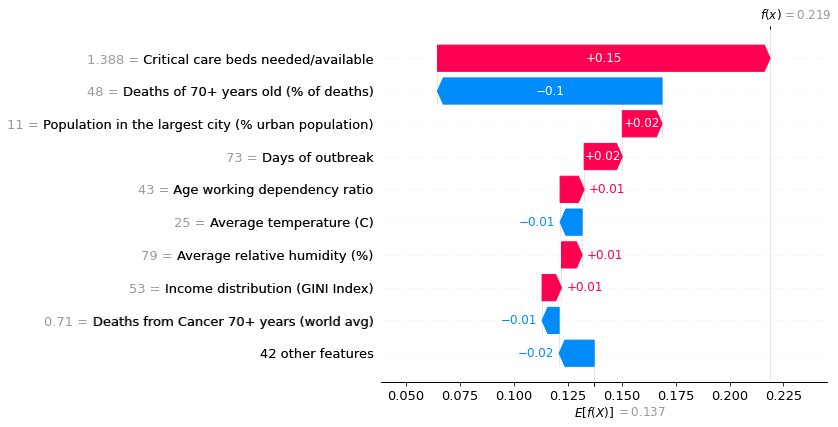

45 0.227632 0.2323287021439889


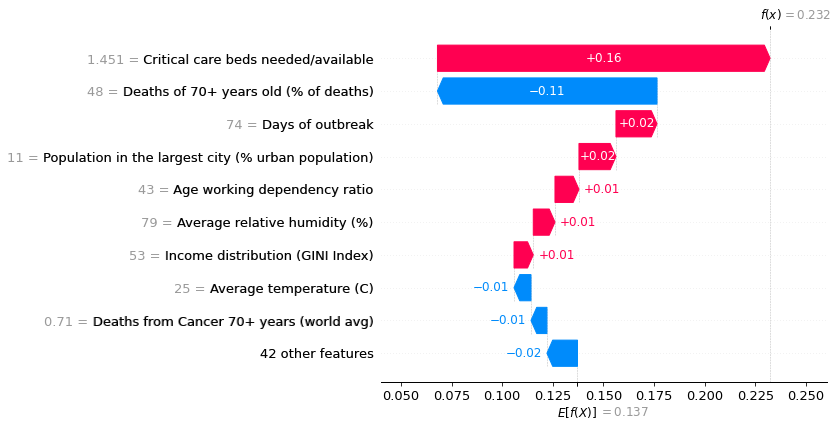

46 0.238934 0.23609798381896568


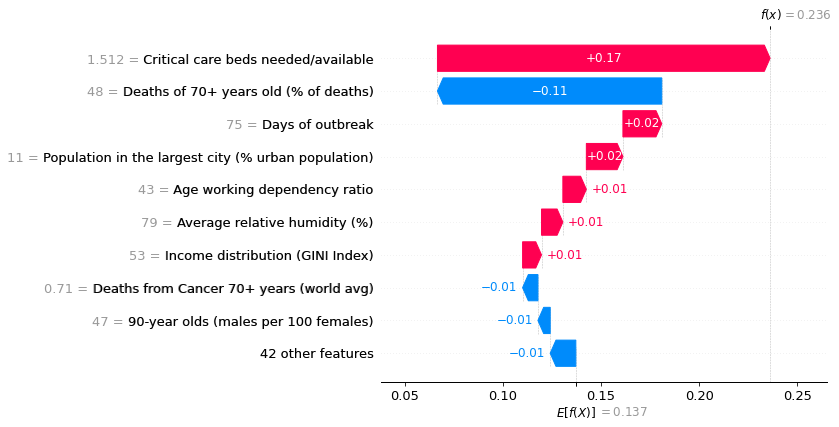

47 0.246457 0.24930915105385765


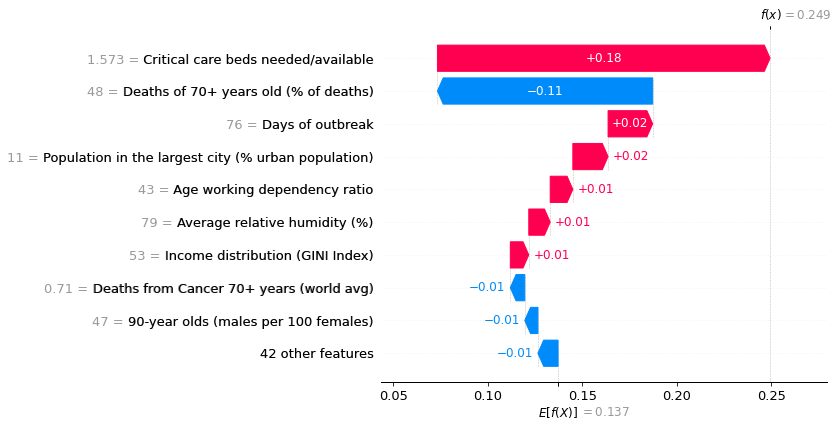

48 0.253947 0.2523486052656704


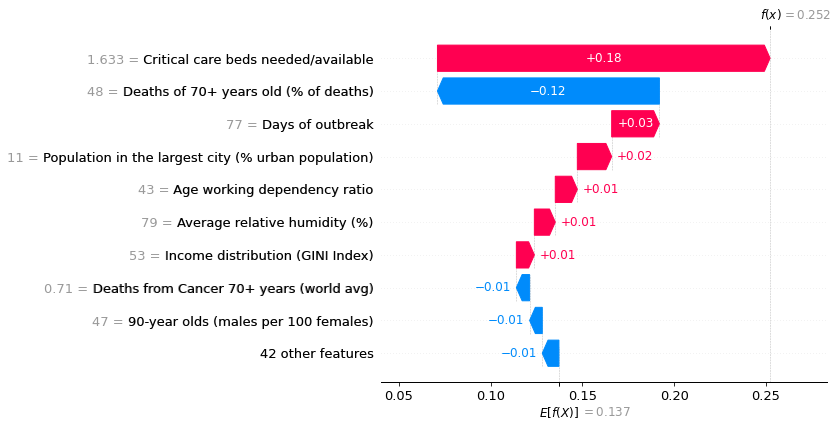

49 0.265069 0.268983045607033


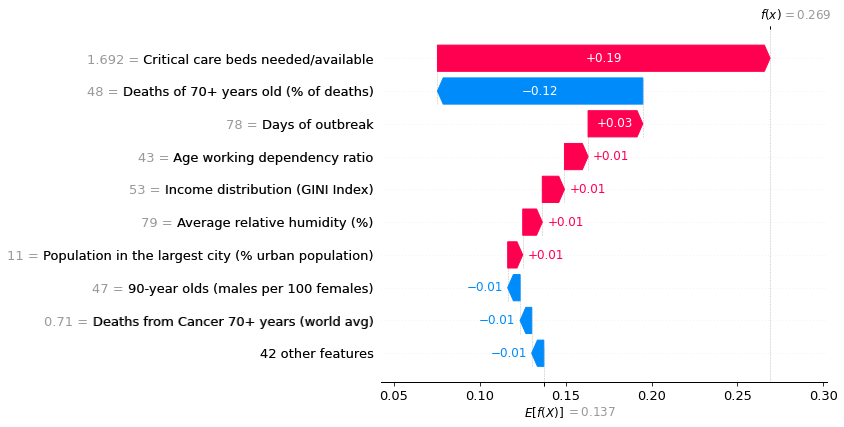

50 0.276029 0.27400757794901726


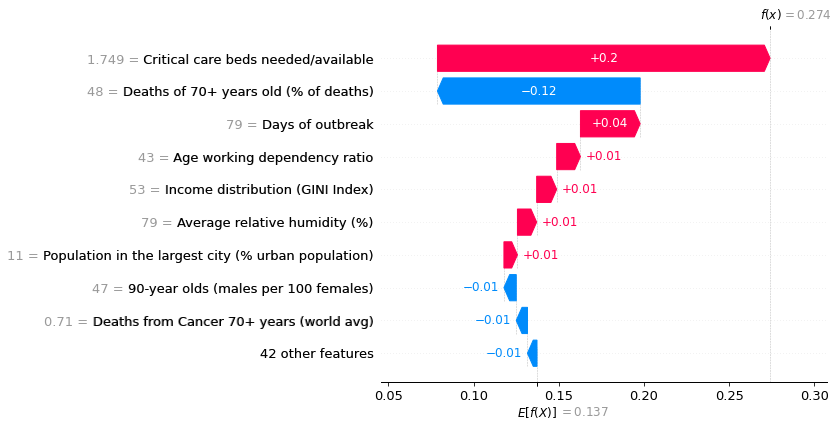

51 0.283194 0.28185534646169197


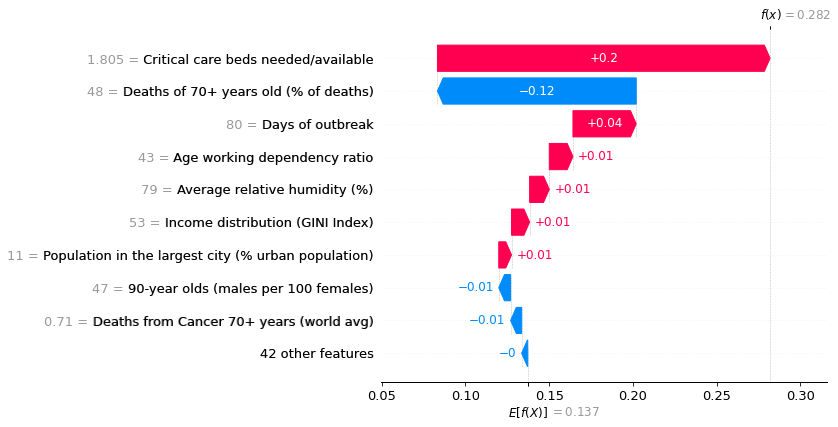

52 0.290229 0.2914440866824194


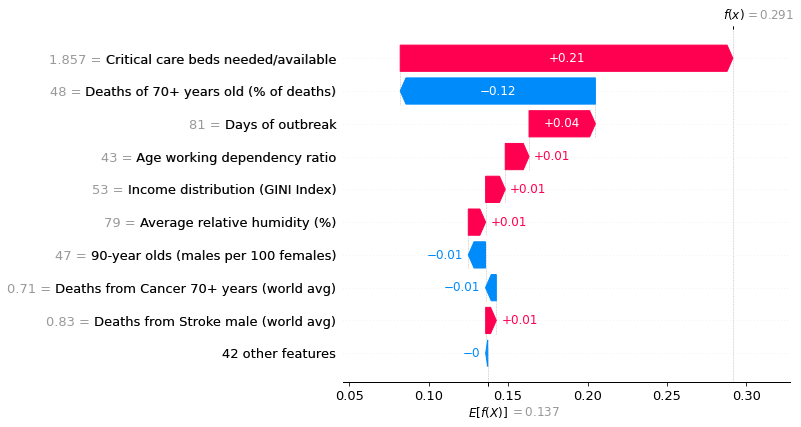

53 0.297114 0.29837547552520555


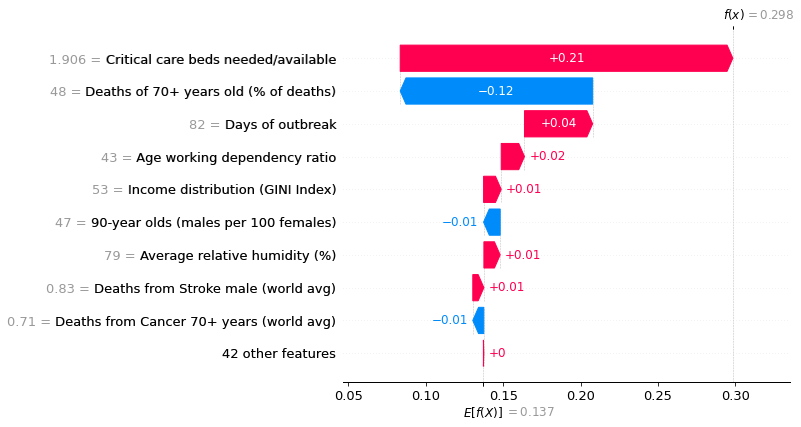

54 0.3071 0.30689387976154175


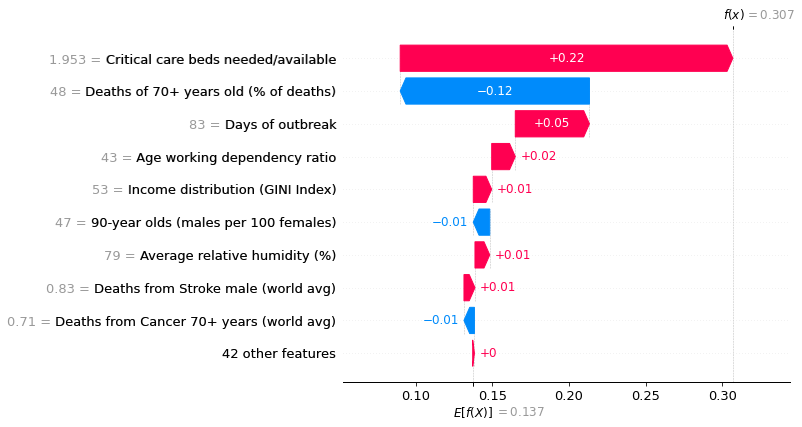

55 0.316704 0.31682153003957864


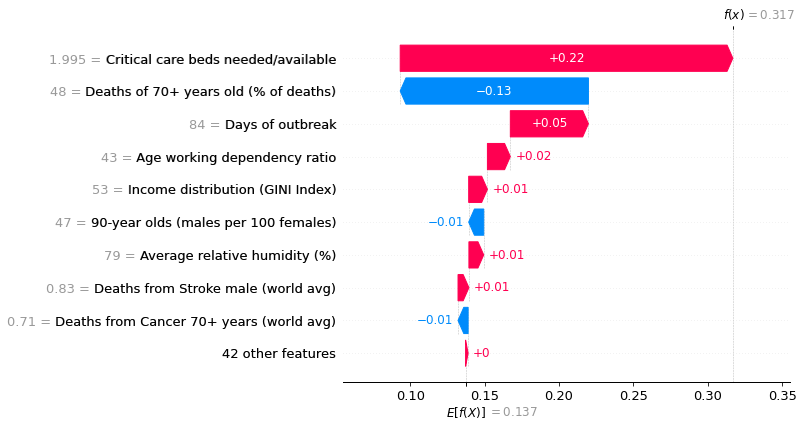

56 0.322828 0.3188207027880577


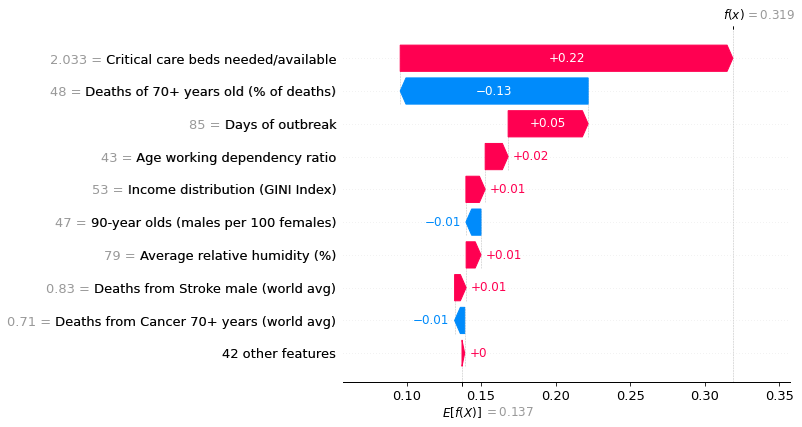

57 0.328726 0.3253206916772664


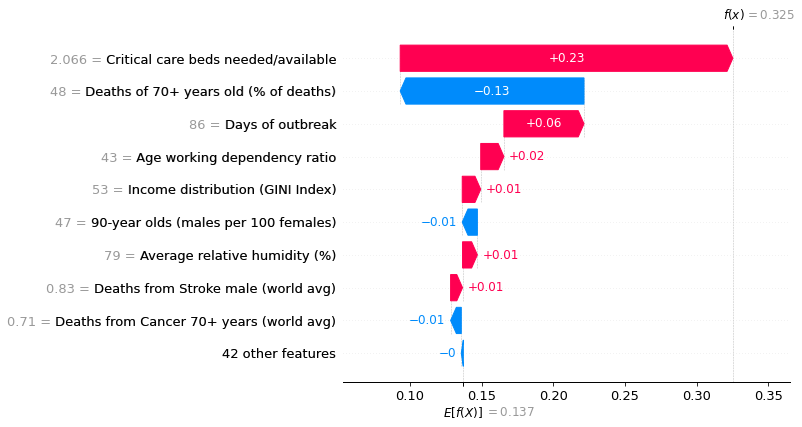

58 0.3371 0.34379084220516015


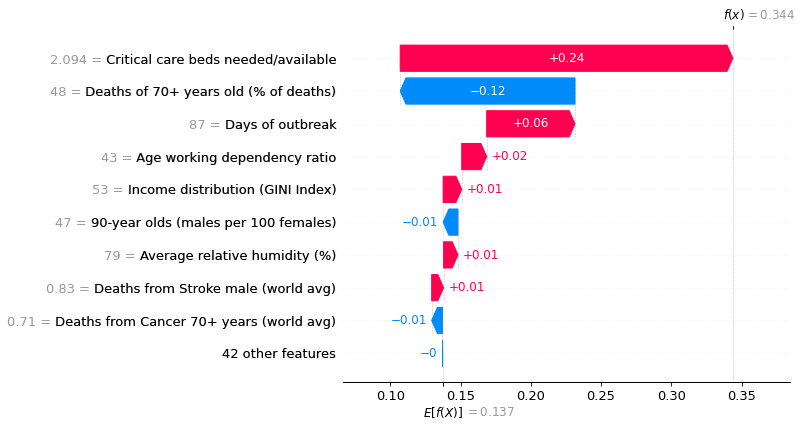

59 0.34498 0.34381140451586345


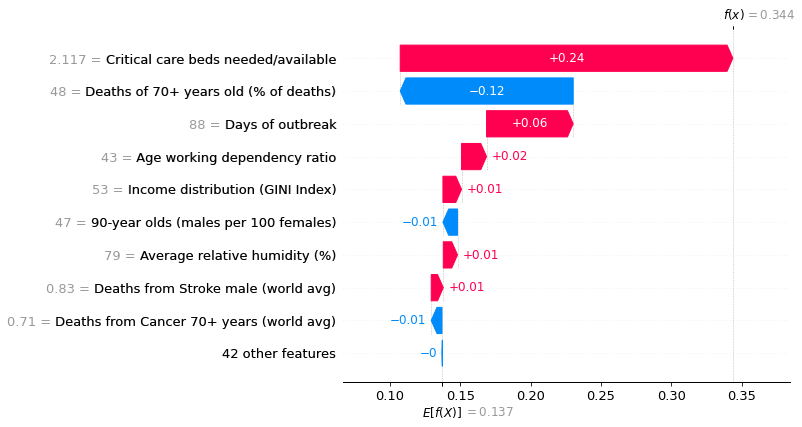

60 0.349896 0.35092687109882514


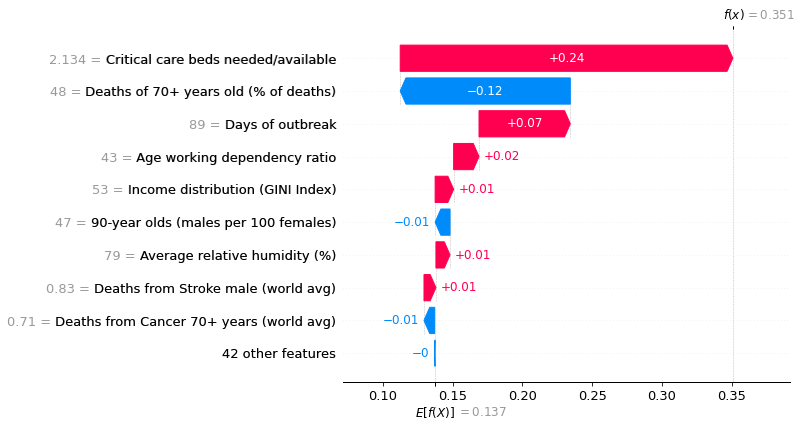

61 0.354555 0.35550170233582196


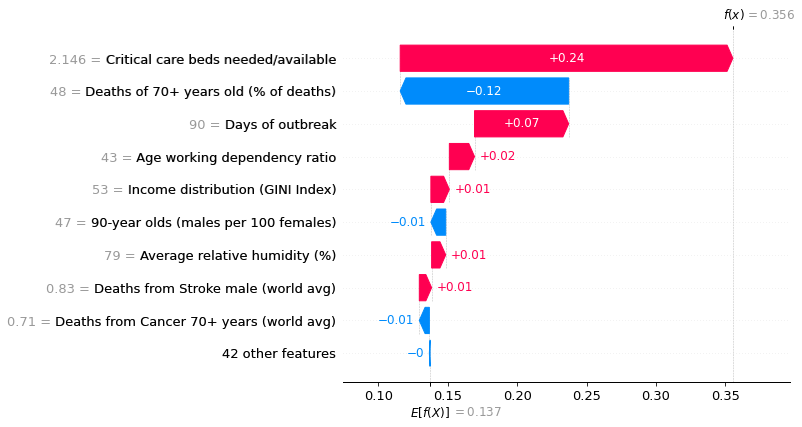

62 0.358956 0.3589555904055007


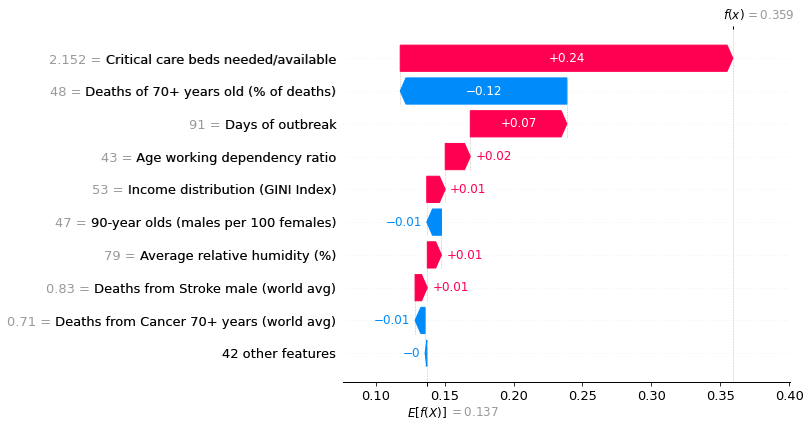

63 0.365043 0.363038989429759


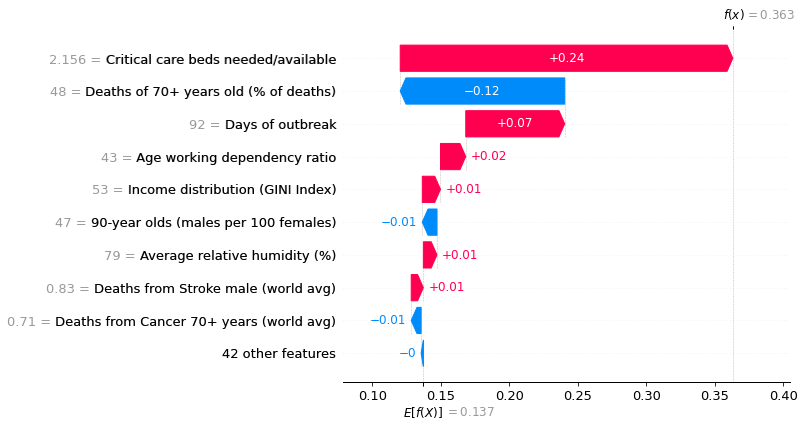

64 0.370626 0.36447951197007866


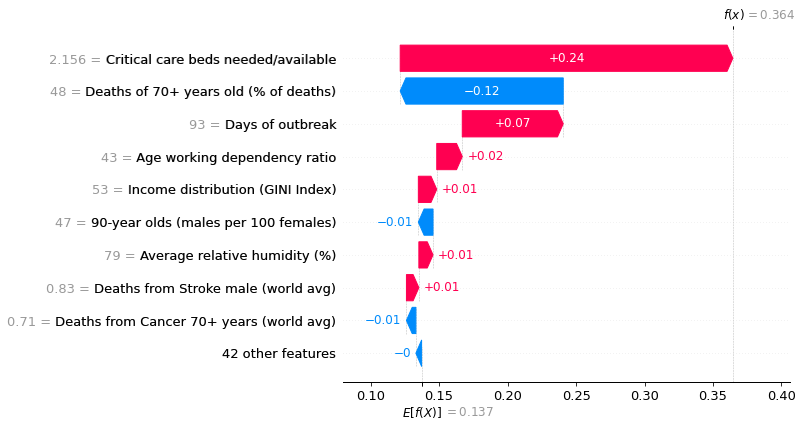

65 0.37402 0.3771554340860476


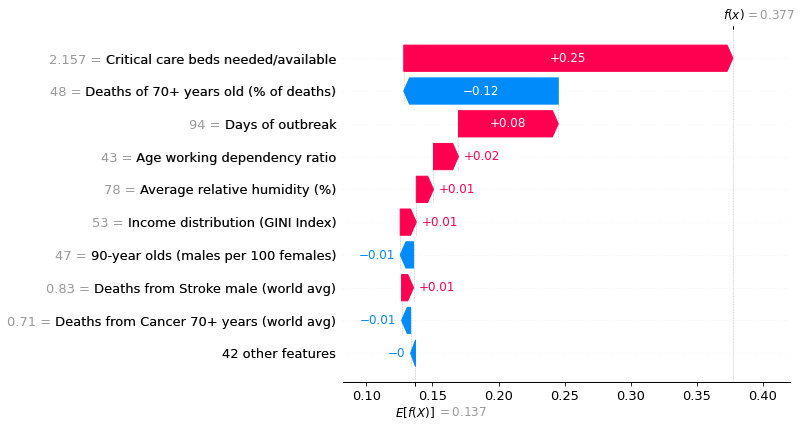

66 0.377176 0.3762405653340558


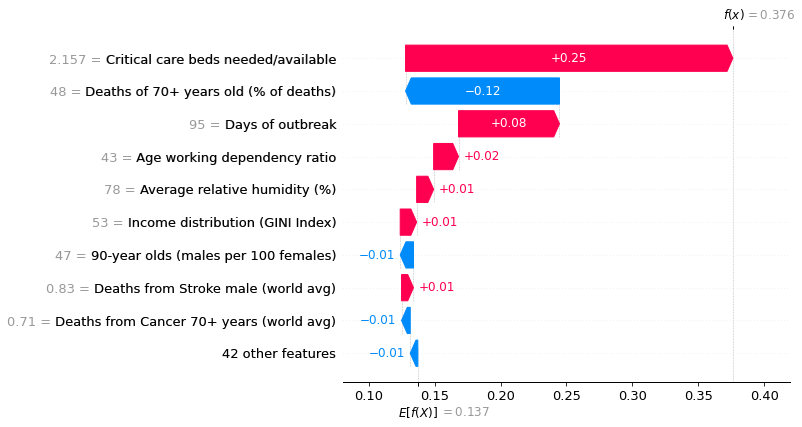

67 0.380101 0.3789477212025093


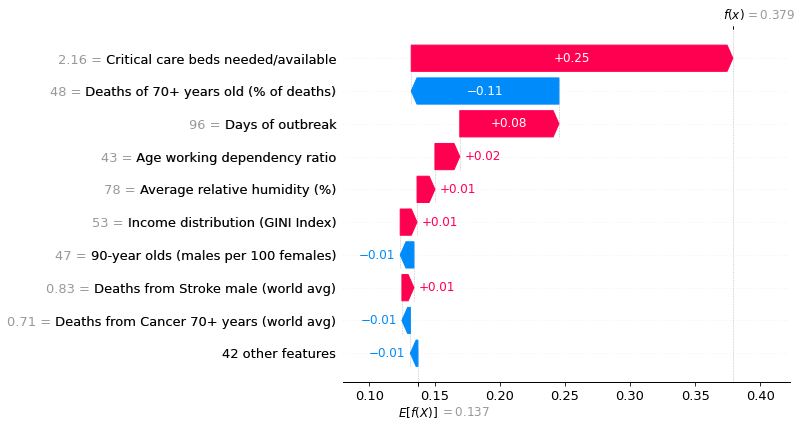

68 0.384053 0.38194206572871703


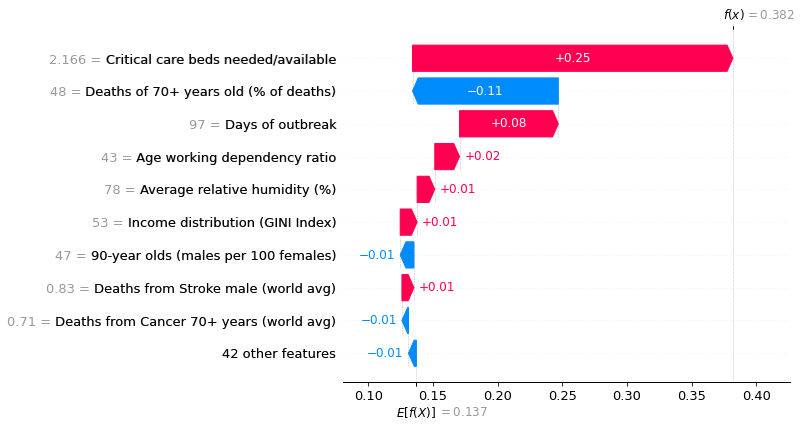

69 0.387594 0.38479385600278626


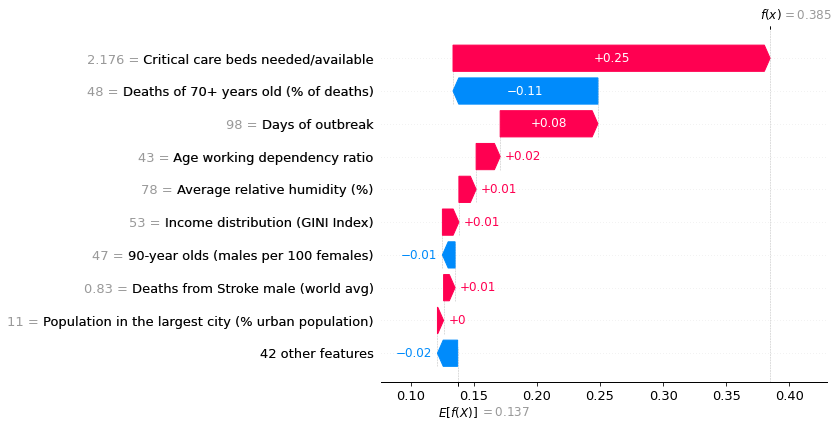

70 0.389699 0.3924962466719512


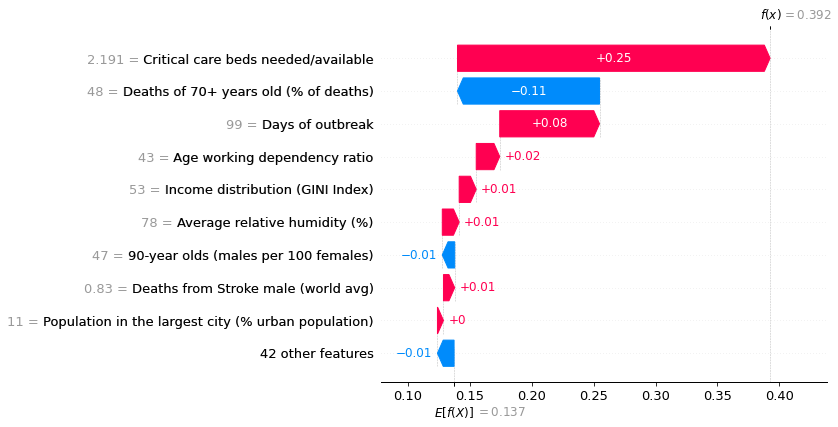

71 0.391627 0.3983074852375356


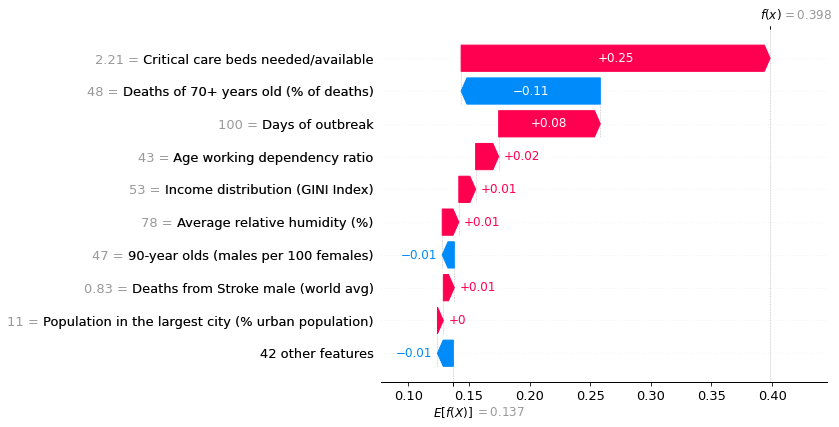

72 0.394193 0.3983889441876566


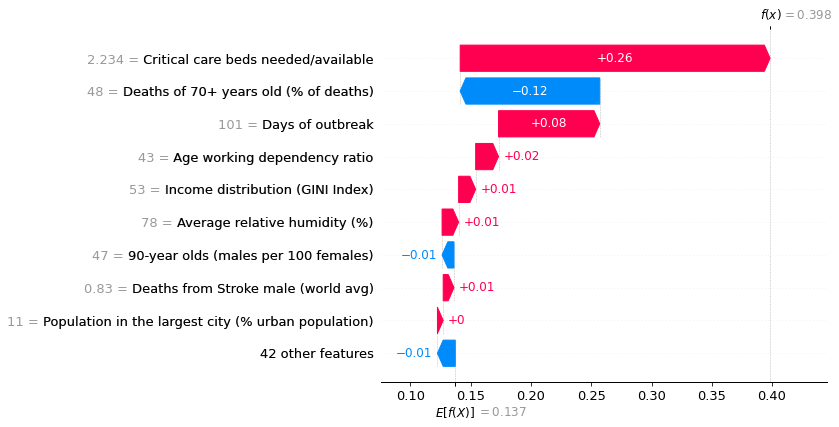

73 0.396464 0.39715413793175686


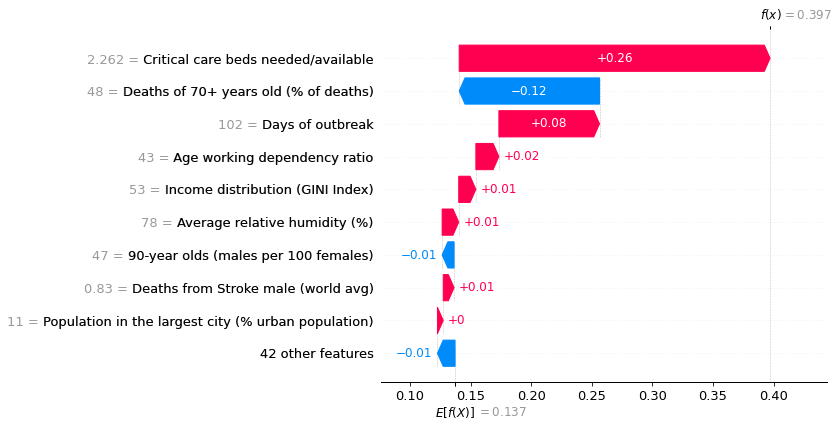

74 0.397801 0.3895713289011107


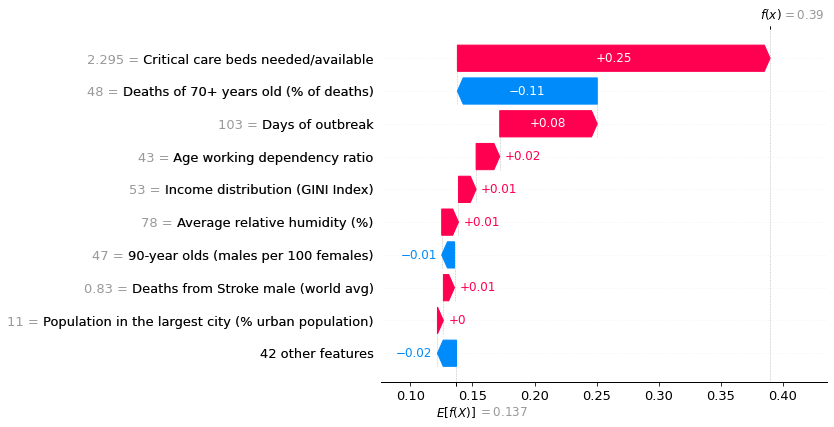

75 0.39902 0.4009396476642122


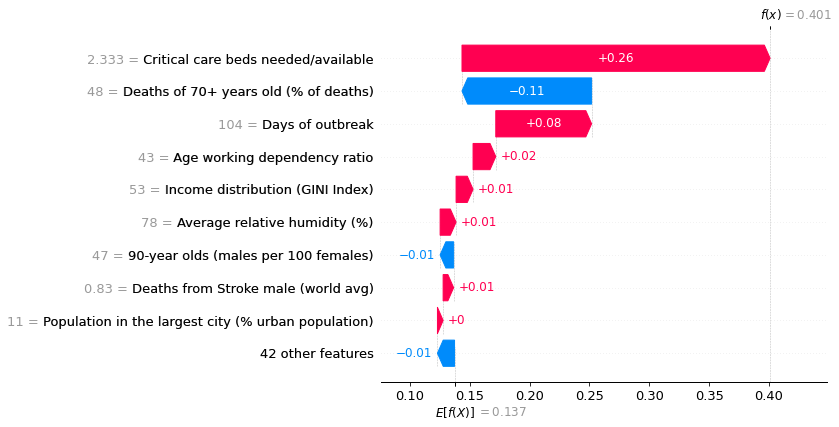

76 0.400131 0.4009396476642122


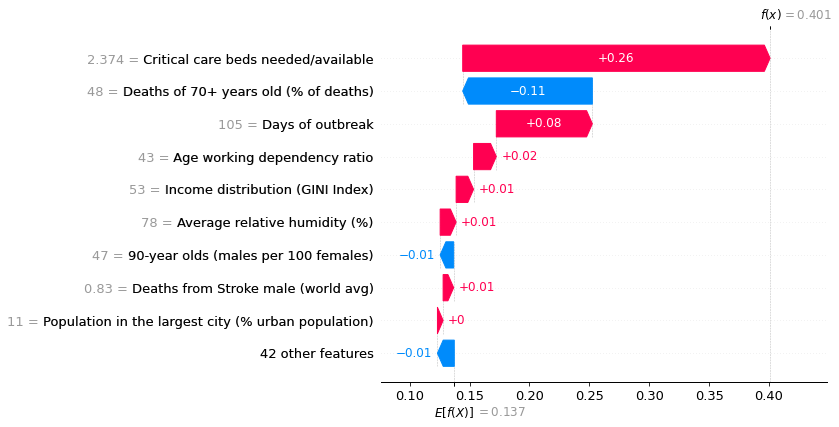

77 0.401609 0.4009396476642122


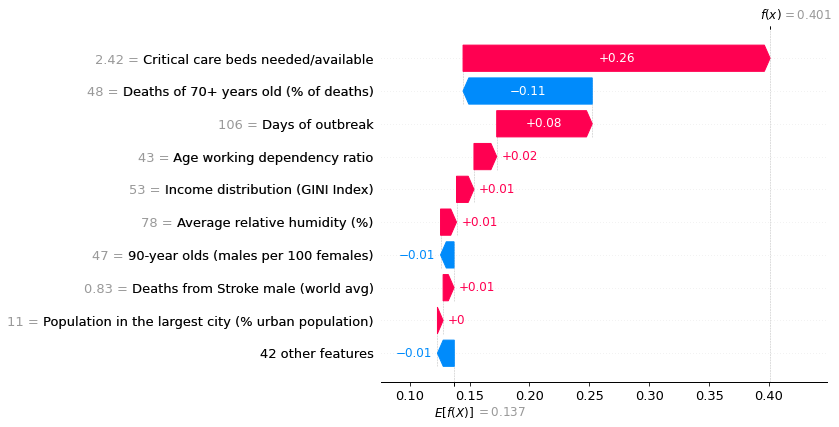

In [ ]:
df1 = pd.read_csv('train-BRAZIL.csv')
df2 = pd.read_csv('val-BRAZIL.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0: features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)
    print(i, y_val[i], y_pred[i])
    
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-br-v',i), bbox_inches='tight', dpi=300)
    plt.clf()
    
   
X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values


for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0: features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-br-a',i), bbox_inches='tight', dpi=300)
    plt.clf()

In [ ]:
df1 = pd.read_csv('train-ITALY.csv')
df2 = pd.read_csv('val-ITALY.csv')

#WANTED_COLUMNS_A = ['Days of outbreak','Schools - days with no measures','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Shelter-in-place - days with no measures','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','International travel - ban arrivals from some regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Critical care beds needed/available','Trend(Critical care beds needed/available)','Diabetes prevalence (% of population)']
WANTED_COLUMNS_A = ['Days of outbreak','Schools - days with no measures','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Shelter-in-place - days with no measures','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','International travel - ban arrivals from some regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Critical care beds needed/available','Diabetes prevalence (% of population)']

#'Public transport - require closing',
#,'Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people'
#'Public events - recommend cancelling',
#'Schools - require closing (only some levels)',
#,'Workplaces - recommend closing','Workplaces - require closing (for some categories)'
#,'Shelter-in-place - recommend not leaving house'
#'Internal movement - recommend not to travel',
#'Schools - recommend closing',
#,'Share of one person households (%)'
#,'Age working dependency ratio'
#'Transit stations percent change from baseline','Residential percent change from baseline',
#,'Population living in slums (% urban population)'
#,'Testing policy - open public testing','Contact tracing - days with no contact tracing'
#,'Testing policy - days with no testing policy'
#,'Public info campaigns - days with no campaign','Public info campaigns - officials urging caution'
#'Debt/contract relief - broad debt/contract relief',
#'International travel - ban on all regions',
#,'International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals'

#X_train = df1[WANTED_COLUMNS_V]
#X_val = df2[WANTED_COLUMNS_V]

#y_train = df1[LABEL_COLUMN_NAME1].values
#y_val = df2[LABEL_COLUMN_NAME1].values

#for i in range(len(y_val)):
#    features = []
#    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
#    X_train = df1[WANTED_COLUMNS_V]
#    X_val = df2[WANTED_COLUMNS_V]
#    for j in range(len(X_val.values[i])):
#        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
#    X_train = df1[features]
#    X_val = df2[features]

#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
#    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

#    explainer = shap.TreeExplainer(gbm)
#    y_pred  = gbm.predict(X_val)
#    shap_values = explainer.shap_values(X_val)

#    print(i, y_val[i], y_pred[i])
#    shap2.shap.waterfall_plot(
#        explainer.expected_value,
#        shap_values[i],
#        features=X_val.values[i],
#        feature_names=features,
#        max_display=MAX_DISPLAY,
#        show=False
#    )
#    plt.savefig('{0}{1}.eps'.format('water-it-v',i), bbox_inches='tight', dpi=300)
#    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0: features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    MAX_DISPLAY=24
    
    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-it-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:
df1 = pd.read_csv('train-GERMANY.csv')
df2 = pd.read_csv('val-GERMANY.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-ger-v',i), bbox_inches='tight', dpi=300)
    plt.clf()

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-ger-a',i), bbox_inches='tight', dpi=300)
    plt.clf()

In [ ]:
df1 = pd.read_csv('train-NETHERLANDS.csv')
df2 = pd.read_csv('val-NETHERLANDS.csv')

#X_train = df1[WANTED_COLUMNS_V]
#X_val = df2[WANTED_COLUMNS_V]

#y_train = df1[LABEL_COLUMN_NAME1].values
#y_val = df2[LABEL_COLUMN_NAME1].values

#for i in range(len(y_val)):
#    features = []
#    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
#    X_train = df1[WANTED_COLUMNS_V]
#    X_val = df2[WANTED_COLUMNS_V]
#    for j in range(len(X_val.values[i])):
#        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
#    X_train = df1[features]
#    X_val = df2[features]

#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
#    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

#    explainer = shap.TreeExplainer(gbm)
#    y_pred  = gbm.predict(X_val)
#    shap_values = explainer.shap_values(X_val)

#    print(i, y_val[i], y_pred[i])
#    shap2.shap.waterfall_plot(
#        explainer.expected_value,
#        shap_values[i],
#        features=X_val.values[i],
#        feature_names=features,
#        max_display=MAX_DISPLAY,
#        show=False
#    )
#    plt.savefig('{0}{1}.eps'.format('water-net-v',i), bbox_inches='tight', dpi=300)
#    plt.clf()

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-net-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-SWITZERLAND.csv')
df2 = pd.read_csv('val-SWITZERLAND.csv')


X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-swi-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-swi-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-USA.csv')
df2 = pd.read_csv('val-USA.csv')


X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-usa-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-usa-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-UK.csv')
df2 = pd.read_csv('val-UK.csv')

#X_train = df1[WANTED_COLUMNS_V]
#X_val = df2[WANTED_COLUMNS_V]

#y_train = df1[LABEL_COLUMN_NAME1].values
#y_val = df2[LABEL_COLUMN_NAME1].values

#for i in range(len(y_val)):
#    features = []
#    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
#    X_train = df1[WANTED_COLUMNS_V]
#    X_val = df2[WANTED_COLUMNS_V]
#    for j in range(len(X_val.values[i])):
#        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
#    X_train = df1[features]
#    X_val = df2[features]

#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
#    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

#    explainer = shap.TreeExplainer(gbm)
#    y_pred  = gbm.predict(X_val)
#    shap_values = explainer.shap_values(X_val)

#    print(i, y_val[i], y_pred[i])
#    shap2.shap.waterfall_plot(
#        explainer.expected_value,
#        shap_values[i],
#        features=X_val.values[i],
#        feature_names=features,
#        max_display=MAX_DISPLAY,
#        show=False
#    )
#    plt.savefig('{0}{1}.eps'.format('water-uk-v',i), bbox_inches='tight', dpi=300)
#    plt.clf()

#WANTED_COLUMNS_A = ['Days of outbreak','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Critical care beds needed/available','Diabetes prevalence (% of population)']

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-uk-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-SWEDEN.csv')
df2 = pd.read_csv('val-SWEDEN.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-sw-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-sw-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-SPAIN.csv')
df2 = pd.read_csv('val-SPAIN.csv')

#X_train = df1[WANTED_COLUMNS_V]
#X_val = df2[WANTED_COLUMNS_V]

#y_train = df1[LABEL_COLUMN_NAME1].values
#y_val = df2[LABEL_COLUMN_NAME1].values

#for i in range(len(y_val)):
#    features = []
#    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
#    X_train = df1[WANTED_COLUMNS_V]
#    X_val = df2[WANTED_COLUMNS_V]
#    for j in range(len(X_val.values[i])):
#        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
#    X_train = df1[features]
#    X_val = df2[features]

#    lgb_train = lgb.Dataset(X_train, y_train)
#    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
#    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

#    explainer = shap.TreeExplainer(gbm)
#    y_pred  = gbm.predict(X_val)
#    shap_values = explainer.shap_values(X_val)

#    print(i, y_val[i], y_pred[i])
#    shap2.shap.waterfall_plot(
#        explainer.expected_value,
#        shap_values[i],
#        features=X_val.values[i],
#        feature_names=features,
#        max_display=MAX_DISPLAY,
#        show=False
#    )
#    plt.savefig('{0}{1}.eps'.format('water-sp-v',i), bbox_inches='tight', dpi=300)
#    plt.clf()

#WANTED_COLUMNS_A = ['Days of outbreak','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - days with no measures','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - days with no restrictions','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Public transport - recommend closing','Public transport - require closing','Shelter-in-place - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with exceptions)','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - days with no measures','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Testing policy - anyone with symptoms','Testing policy - open public testing','Contact tracing - days with no contact tracing','Critical care beds needed/available','Diabetes prevalence (% of population)']

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-sp-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-IRAN.csv')
df2 = pd.read_csv('val-IRAN.csv')


X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-iran-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-iran-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-PAKISTAN.csv')
df2 = pd.read_csv('val-PAKISTAN.csv')


X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-pakistan-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-pakistan-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-FRANCE.csv')
df2 = pd.read_csv('val-FRANCE.csv')


X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-fr-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-fr-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-SLOVAKIA.csv')
df2 = pd.read_csv('val-SLOVAKIA.csv')

#WANTED_COLUMNS_V = ['Days of outbreak','Death rate from CVDs (per 100k)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 70 years and older (% of population)','40-year olds (males per 100 females)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Population in the largest city (% urban population)','Urban population (% population)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Deaths from Stroke female (world avg)','Deaths from Stroke male (world avg)','Current health expenditure (% of GDP)','Agglomerations of +1 million (% of urban population)','Share infected with HIV (% of population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from Diabetes female (world avg)','Deaths from Diabetes male (world avg)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Deaths of 70+ years old (% of deaths)','Deaths of 50 to 69 years old (% of deaths)','Deaths of 15 to 49 years old (% of deaths)','Deaths from AIDS female (world avg)','Deaths from AIDS male (world avg)','Deaths from Cancer 15-49 years (world avg)','Deaths from CVDs 15-49 years (world avg)','Deaths from Diabetes 15-49 years (world avg)','Deaths from Cancer 50-69 years (world avg)','Deaths from CVDs 50-69 years (world avg)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','BCG coverage (%)','Critical care beds needed/available','Average temperature (C)','Average relative humidity (%)']

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-slovakia-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-slovakia-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-DENMARK.csv')
df2 = pd.read_csv('val-DENMARK.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-denmark-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-denmark-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-NORWAY.csv')
df2 = pd.read_csv('val-NORWAY.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-norway-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-norway-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:

df1 = pd.read_csv('train-CANADA.csv')
df2 = pd.read_csv('val-CANADA.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-canada-v',i), bbox_inches='tight', dpi=300)
    plt.clf()


X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-canada-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:
df1 = pd.read_csv('train-BELGIUM.csv')
df2 = pd.read_csv('val-BELGIUM.csv')

X_train = df1[WANTED_COLUMNS_V]
X_val = df2[WANTED_COLUMNS_V]

y_train = df1[LABEL_COLUMN_NAME1].values
y_val = df2[LABEL_COLUMN_NAME1].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_V)): features.insert(len(features), WANTED_COLUMNS_V[j])
    X_train = df1[WANTED_COLUMNS_V]
    X_val = df2[WANTED_COLUMNS_V]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == 0 or X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]): features.remove(str(WANTED_COLUMNS_V[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-belgium-v',i), bbox_inches='tight', dpi=300)
    plt.clf()

X_train = df1[WANTED_COLUMNS_A]
X_val = df2[WANTED_COLUMNS_A]

y_train = df1[LABEL_COLUMN_NAME2].values
y_val = df2[LABEL_COLUMN_NAME2].values

for i in range(len(y_val)):
    features = []
    for j in range(len(WANTED_COLUMNS_A)): features.insert(len(features), WANTED_COLUMNS_A[j])
    X_train = df1[WANTED_COLUMNS_A]
    X_val = df2[WANTED_COLUMNS_A]
    for j in range(len(X_val.values[i])):
        if X_val.values[i][j] == -999998 or np.isnan(X_val.values[i][j]) or X_val.values[i][j] == 0:features.remove(str(WANTED_COLUMNS_A[j]))
    X_train = df1[features]
    X_val = df2[features]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(gbm)
    y_pred  = gbm.predict(X_val)
    shap_values = explainer(X_val)

    print(i, y_val[i], y_pred[i])
    shap.plots.waterfall(
        #explainer.expected_value,
        shap_values[i],
        #features=X_val.values[i],
        #feature_names=features,
        #max_display=MAX_DISPLAY,
        #show=False
    )
    plt.savefig('{0}{1}.eps'.format('water-belgium-a',i), bbox_inches='tight', dpi=300)
    plt.clf()


In [ ]:
df1 = pd.read_csv('peak_acceleration.csv')

WANTED_COLUMNS_V = ['Population living in slums (% urban population)','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - recommend not to travel','Internal movement - restrictions in place','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Public info campaigns - coordinated campaign','Testing policy - days with no testing policy','Contact tracing - days with no contact tracing','Contact tracing - limited contact tracing','Contact tracing - comprehensive contact tracing','Average temperature (C)','Average relative humidity (%)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 25 years and older (% of population)','Share that is 50 years and older (% of population)','Share that is 70 years and older (% of population)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Age working dependency ratio','Share of one person households (%)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Nurses available (per 100k)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Diabetes prevalence (% of population)','Share infected with HIV (% of population)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Current health expenditure (% of GDP)','Out-of-pocket expenditure (% health expenditure)','Agglomerations of +1 million (% of urban population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Critical care beds needed/available']
MD=35
#C = 'Reds'
C = 'bwr'

X = df1[WANTED_COLUMNS_V]
y = df1[LABEL_COLUMN_NAME1].values
lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(params, lgb_train, num_boost_round=100, verbose_eval=False)
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

shap_interaction_values = explainer.shap_interaction_values(X)

#shap2.shap.summary_plot(shap_interaction_values, X, WANTED_COLUMNS_V, max_display=MD,
#             plot_type='compact_dot',
shap2.shap.summary_plot(shap_values, X, WANTED_COLUMNS_V, max_display=MD,
             plot_type='dot',
             alpha=0.75,
             color = C,
             show=False,
             sort=True,
             color_bar=False,
             plot_size=0.3
)
plt.savefig('{0}.eps'.format('summary-peak-acceleration'), bbox_inches='tight', dpi=300)
plt.clf()

WANTED_COLUMNS_V = ['Population living in slums (% urban population)','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Workplaces - recommend closing','Workplaces - require closing (for some categories)','Workplaces - require closing (all-but-essential)','Public events - days with no measures','Public events - recommend cancelling','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - require closing','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','International travel - ban on all regions','Income - days with no income support','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Public info campaigns - coordinated campaign','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Contact tracing - days with no contact tracing','Contact tracing - limited contact tracing','Average temperature (C)','Average relative humidity (%)','Income distribution (GINI Index)','Population density (inhabitants per Km2)','Share that is 25 years and older (% of population)','Share that is 50 years and older (% of population)','Share that is 70 years and older (% of population)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Age working dependency ratio','Share of one person households (%)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Nurses available (per 100k)','Share of men who smoke (% male population)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Diabetes prevalence (% of population)','Share infected with HIV (% of population)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Current health expenditure (% of GDP)','Out-of-pocket expenditure (% health expenditure)','Agglomerations of +1 million (% of urban population)','Deaths from Cancer female (world avg)','Deaths from Cancer male (world avg)','Deaths from Cancer 15-49 years (world avg)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Critical care beds needed/available']
df1 = pd.read_csv('peak_velocity.csv')
X = df1[WANTED_COLUMNS_V]
y = df1[LABEL_COLUMN_NAME1].values
lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(params, lgb_train, num_boost_round=100, verbose_eval=False)
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)
shap2.shap.summary_plot(shap_values, X, WANTED_COLUMNS_V, max_display=MD,
             plot_type='dot',
             alpha=0.75,
             color = C,
             show=False,
             sort=True,
             color_bar=False,
             plot_size=0.3
)
plt.savefig('{0}.eps'.format('summary-peak-velocity'), bbox_inches='tight', dpi=300)
plt.clf()

WANTED_COLUMNS_V = ['Population living in slums (% urban population)','Schools - days with no measures','Schools - recommend closing','Schools - require closing (only some levels)','Schools - require closing (all levels)','Workplaces - recommend closing','Public events - days with no measures','Public events - recommend cancelling','Public events - require cancelling','Private gatherings - above 1000 people','Private gatherings - 101 to 1000 people','Private gatherings - 11 to 100 people','Private gatherings - 10 or less people','Public transport - days with no measures','Shelter-in-place - recommend not leaving house','Shelter-in-place - require not leaving house (with minimal exceptions)','Internal movement - recommend not to travel','International travel - days with no restrictions','International travel - screening arrivals','International travel - quarantine arrivals','International travel - ban arrivals from some regions','Debt/contract relief - days with no debt/contract relief','Debt/contract relief - narrow relief','Debt/contract relief - broad debt/contract relief','Public info campaigns - days with no campaign','Public info campaigns - officials urging caution','Public info campaigns - coordinated campaign','Testing policy - days with no testing policy','Testing policy - only symptoms/specific criteria','Contact tracing - days with no contact tracing','Contact tracing - limited contact tracing','Contact tracing - comprehensive contact tracing','Average temperature (C)','Average relative humidity (%)','Income distribution (GINI Index)','Share that is 25 years and older (% of population)','Share that is 50 years and older (% of population)','Share that is 70 years and older (% of population)','50-year olds (males per 100 females)','60-year olds (males per 100 females)','70-year olds (males per 100 females)','80-year olds (males per 100 females)','90-year olds (males per 100 females)','100-year olds (males per 100 females)','Age working dependency ratio','Share of one person households (%)','Population in the largest city (% urban population)','Urban population (% population)','Long-term care beds (per 100k aged 70+)','Nurses available (per 100k)','Share of women who smoke (% female population)','Share of men who are obese (% male population)','Share of women who are obese (% female population)','Diabetes prevalence (% of population)','Share infected with HIV (% of population)','Current BCG vaccination','BCG vaccination started (years)','BCG vaccination stopped (years)','Urban areas over 500k inhabitants','Urban areas over 1M inhabitants','Urban areas over 2M inhabitants','Urban areas over 5M inhabitants','Out-of-pocket expenditure (% health expenditure)','Agglomerations of +1 million (% of urban population)','Deaths from Cancer 70+ years (world avg)','Deaths from CVDs 70+ years (world avg)','Deaths from Diabetes 70+ years (world avg)','Critical care beds needed/available']

df1 = pd.read_csv('last.csv')
X = df1[WANTED_COLUMNS_V]
y = df1[LABEL_COLUMN_NAME1].values
lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(params, lgb_train, num_boost_round=100, verbose_eval=False)
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)
shap2.shap.summary_plot(shap_values, X, WANTED_COLUMNS_V, max_display=MD,
             plot_type='dot',
             alpha=0.75,
             color = C,
             show=False,
             sort=True,
             color_bar=False,
             plot_size=0.3
)
plt.savefig('{0}.eps'.format('summary-last'), bbox_inches='tight', dpi=300)
plt.clf()
